# Importações e instalações iniciais

In [1]:
import pandas as pd
import csv
import gc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import dates
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline
import gc
from pandas.plotting import autocorrelation_plot
#import itertools
#from statsmodels.tsa.holtwinters import ExponentialSmoothing
from numpy import array
import scipy.stats as stats
import textwrap
from collections import Counter


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Agrupar dataset de transtorno mentais (primeira vez)


In [ ]:
anos = [f'{i:02}' for i in range(6, 24)]

resultados_por_ano = []
tamanho = 0

for ano in anos:
    caminho_arquivo = f'/content/drive/Shareddrives/DEVDIS/TranstornosMentais/MENTBR{ano}.csv'

    tamanho = 0
    # Leitura incremental do arquivo
    for df_temp in pd.read_csv(caminho_arquivo, sep=',', chunksize=100000, low_memory=False, dtype='unicode', encoding='iso-8859-1'):

        # Filtra os dados relevantes
        df = df_temp.copy()
        #df = df_temp[df_temp['DIAG_ESP'].str.startswith('Z73').copy()
        #df = df_temp[(df_temp['CLASSI_FIN']== '3') | (df_temp['CLASSI_FIN']== '12')].copy()

        df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce', format='%Y-%m-%d')

        # Agrupa os dados
        resultados_por_ano.append(df[['DT_NOTIFIC', 'DIAG_ESP', 'SG_UF_NOT',  'UF_EMP',
                                      'NU_IDADE_N','ID_OCUPA_N','SIT_TRAB', 'NUTEMPO', 'TPTEMPO',
                                      'CS_SEXO', 'ALCOOL', 'PSICO_FARM', 'DROGAS', 'FUMA', 'TEMPO_FUMA',
                                      'TP_TEMP_FU', 'REGIME', 'CAPES','EVOLUCAO', 'CAT']])

        tamanho = df.shape[0] + tamanho

        # Descarta os dados não utilizados
        del df, df_temp
        gc.collect()

    print('Dataset: {} , Transtornos mentais rows: {}'.format(ano, tamanho))

# Concatena os resultados
resultado_final = pd.concat(resultados_por_ano, axis=0)

In [ ]:
df = pd.DataFrame(resultado_final)
df = df.reset_index(drop=True)

In [ ]:
df_backup = df.copy()
df.to_csv('/content/drive/Shareddrives/DEVDIS/TranstornosMentais/transtornos_mentais.csv', index=False)

# Carregar dataset de transtornos mentais SINAN e populacao IBGE

In [4]:
df = pd.read_csv('/content/drive/Shareddrives/DEVDIS/TranstornosMentais/transtornos_mentais.csv', sep=',', dtype='unicode', encoding='iso-8859-1')

In [5]:
#Transformar em index
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'])
df.set_index('DT_NOTIFIC', inplace=True)
df = df.sort_index()
df = df['2009':]

df['ANO'] = df.index.year

In [6]:
#df_ocupacao = pd.read_csv('/content/drive/Shareddrives/DEVDIS/TranstornosMentais/CBO2002_Ocupacao.csv', sep=';', dtype='unicode', encoding='iso-8859-1')
#df_ocupacao = pd.read_csv('/content/drive/Shareddrives/DEVDIS/TranstornosMentais/CBO2002_Familia.csv', sep=';', dtype='unicode', encoding='iso-8859-1')
#df_ocupacao.columns = ['ID_OCUPA_N', 'DESCRICAO']

In [7]:
#df_area = pd.read_csv('/content/drive/Shareddrives/DEVDIS/TranstornosMentais/cnae.csv', sep=';', dtype='unicode')
#df_ocupacao = pd.read_csv('/content/drive/Shareddrives/DEVDIS/TranstornosMentais/CBO2002_Familia.csv', sep=';', dtype='unicode', encoding='iso-8859-1')
#df_area.drop(columns='DESCRICAO', inplace=True)
#df_area.columns = ['ID_OCUPA_N', 'AREA']

df_ocupacao_area = pd.read_csv('/content/drive/Shareddrives/DEVDIS/TranstornosMentais/cnae_ocupacao.csv', sep=';', dtype='unicode')
df_ocupacao_area.columns = ['ID_OCUPA_N', 'DESCRICAO', 'AREA']

In [8]:
df_pop = pd.read_csv('/content/drive/Shareddrives/DEVDIS/Populacao/IBGE.csv')
df_pop.columns = ['UF', 'CODIGO_IBGE'] + [f'{ano}_populacao' for ano in range(2008, 2025)]
df_pop.columns = df_pop.columns.str.replace('_populacao', '')

In [9]:
df_empregos = pd.read_csv('/content/drive/Shareddrives/DEVDIS/Populacao/dados_ocupados_sp.csv', sep=',', dtype='unicode', encoding='iso-8859-1')
df_empregos.columns=['TRIMESTRE', 'QTD_OCUPADOS']
df_empregos['TRIMESTRE'] = pd.to_datetime(df_empregos['TRIMESTRE'], errors='coerce')
df_empregos['QTD_OCUPADOS'] = df_empregos['QTD_OCUPADOS'].astype(int)

In [10]:
df[df['DIAG_ESP'].str.contains('B3', na=False)]

,DIAG_ESP,SG_UF_NOT,UF_EMP,NU_IDADE_N,ID_OCUPA_N,SIT_TRAB,NUTEMPO,TPTEMPO,CS_SEXO,ALCOOL,PSICO_FARM,DROGAS,FUMA,TEMPO_FUMA,TP_TEMP_FU,REGIME,CAPES,EVOLUCAO,CAT,ANO
DT_NOTIFIC,,,,,,,,,,,,,,,,,,,,
2021-06-02,B342,29,29,4052,950205,09,0,NaN,M,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,9,2021


#Entendimento e Preparação dos Dados

In [11]:
def transf_mes_ano(df_mes):
  df_mes['MESANO'] = df_mes.index.to_period('M')
  df_mes['ANO'] = df_mes.index.to_period('Y')
  s_mes = df_mes['MESANO'].value_counts().sort_index()
  s_mes.index = s_mes.index.to_timestamp()
  s_mes = s_mes.resample('MS').asfreq()

  s_ano = df_mes['ANO'].value_counts().sort_index()
  s_ano.index = s_ano.index.to_timestamp()
  s_ano= s_ano.resample('AS').asfreq()
  return s_mes, s_ano

##Pre-processamento

In [12]:
df_sp = df[df['SG_UF_NOT']=='35'].copy()
df_sp = df_sp['2012':'2023']

df_a = df[df['DIAG_ESP'].str.startswith('F41') & ~df['DIAG_ESP'].isna()].copy()

df_sp_a = df_sp['2012':'2024'].copy()
df_sp_a = df_sp_a[df_sp_a['DIAG_ESP'].str.startswith('F41') & ~df_sp_a['DIAG_ESP'].isna()].copy()

df_sp_a5 = df_sp_a[df_sp_a['DIAG_ESP'].str.startswith('F4') & ~df_sp_a['DIAG_ESP'].isna()].copy()

df_sp_a1 = df_sp['2012':'2019'].copy()
df_sp_a1 = df_sp_a1[df_sp_a1['DIAG_ESP'].str.startswith('F41') & ~df_sp_a1['DIAG_ESP'].isna()].copy()

df_sp_a2 = df_sp['2020':'2024'].copy()
df_sp_a2 = df_sp_a2[df_sp_a2['DIAG_ESP'].str.startswith('F41') & ~df_sp_a2['DIAG_ESP'].isna()].copy()

print(df_sp.shape)
print(df_sp_a.shape)
print(df_sp_a1.shape)
print(df_sp_a2.shape)

(5030, 20)
(1083, 20)
(520, 20)
(563, 20)


In [13]:
df_sp_a['NU_IDADE_N'] = df_sp_a['NU_IDADE_N'].astype('int')
df_sp_a1['NU_IDADE_N'] = df_sp_a1['NU_IDADE_N'].astype('int')
df_sp_a2['NU_IDADE_N'] = df_sp_a2['NU_IDADE_N'].astype('int')

In [14]:
df_sp_a['IDADE'] = df_sp_a['NU_IDADE_N'] - 4000
media_idade = int(df_sp_a.loc[df_sp_a['IDADE'] >= 16, 'IDADE'].mean())
df_sp_a.loc[df_sp_a['IDADE'] < 16, 'IDADE'] = media_idade

df_sp_a1['IDADE'] = df_sp_a1['NU_IDADE_N'] - 4000
media_idade1 = int(df_sp_a1.loc[df_sp_a1['IDADE'] >= 16, 'IDADE'].mean())
df_sp_a1.loc[df_sp_a1['IDADE'] < 16, 'IDADE'] = media_idade1

df_sp_a2['IDADE'] = df_sp_a2['NU_IDADE_N'] - 4000
media_idade2 = int(df_sp_a2.loc[df_sp_a2['IDADE'] >= 16, 'IDADE'].mean())
df_sp_a2.loc[df_sp_a2['IDADE'] < 16, 'IDADE'] = media_idade2

In [15]:
# Definindo os bins de idade
bins = [16, 20, 30, 40, 50, 60, 70, 80]
labels = ['16-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

# Contando as frequências de cada bin para df_sp_a1 (2012-2019)
df_sp_a1['AGE_GROUP'] = pd.cut(df_sp_a1['IDADE'], bins=bins, labels=labels, right=False)


# Contando as frequências de cada bin para df_sp_a2 (2020-2023)
df_sp_a2['AGE_GROUP'] = pd.cut(df_sp_a2['IDADE'], bins=bins, labels=labels, right=False)


# Contando as frequências de cada bin
df_sp_a['AGE_GROUP'] = pd.cut(df_sp_a['IDADE'], bins=bins, labels=labels, right=False)



In [16]:
df_sp_a['ID_OCUPA_N_OLD'] = df_sp_a['ID_OCUPA_N']
df_sp_a['ID_OCUPA_N'] = df_sp_a['ID_OCUPA_N'].astype(str).str[:4]
original_index = df_sp_a.index
df_sp_a = df_sp_a.merge(df_ocupacao_area, on='ID_OCUPA_N', how='left')
df_sp_a = df_sp_a.rename(columns={'DESCRICAO': 'PROFISSAO'})
df_sp_a = df_sp_a.set_index(original_index)

df_sp_a1['ID_OCUPA_N_OLD'] = df_sp_a1['ID_OCUPA_N']
df_sp_a1['ID_OCUPA_N'] = df_sp_a1['ID_OCUPA_N'].astype(str).str[:4]
original_index1 = df_sp_a1.index
df_sp_a1 = df_sp_a1.merge(df_ocupacao_area, on='ID_OCUPA_N', how='left')
df_sp_a1 = df_sp_a1.rename(columns={'DESCRICAO': 'PROFISSAO'})
df_sp_a1 = df_sp_a1.set_index(original_index1)

df_sp_a2['ID_OCUPA_N_OLD'] = df_sp_a2['ID_OCUPA_N']
df_sp_a2['ID_OCUPA_N'] = df_sp_a2['ID_OCUPA_N'].astype(str).str[:4]
original_index2 = df_sp_a2.index
df_sp_a2 = df_sp_a2.merge(df_ocupacao_area, on='ID_OCUPA_N', how='left')
df_sp_a2 = df_sp_a2.rename(columns={'DESCRICAO': 'PROFISSAO'})
df_sp_a2 = df_sp_a2.set_index(original_index2)

print(df_sp_a.shape)
print(df_sp_a1.shape)
print(df_sp_a2.shape)

(1083, 25)
(520, 25)
(563, 25)


In [17]:
df_sp_a['AREA'] = df_sp_a['AREA'].fillna("Não informado")
df_sp_a['PROFISSAO'] = df_sp_a['PROFISSAO'].fillna("Não informado")

df_sp_a1['AREA'] = df_sp_a1['AREA'].fillna("Não informado")
df_sp_a1['PROFISSAO'] = df_sp_a1['PROFISSAO'].fillna("Não informado")

df_sp_a2['AREA'] = df_sp_a2['AREA'].fillna("Não informado")
df_sp_a2['PROFISSAO'] = df_sp_a2['PROFISSAO'].fillna("Não informado")

print(df_sp_a.shape)
print(df_sp_a1.shape)
print(df_sp_a2.shape)

(1083, 25)
(520, 25)
(563, 25)


In [18]:
dict_uf = {
    '11': 'RO', '12': 'AC', '13': 'AM', '14': 'RR', '15': 'PA', '16': 'AP', '17': 'TO',
    '21': 'MA', '22': 'PI', '23': 'CE', '24': 'RN', '25': 'PB', '26': 'PE', '27': 'AL',
    '28': 'SE', '29': 'BA', '31': 'MG', '32': 'ES', '33': 'RJ', '35': 'SP', '41': 'PR',
    '42': 'SC', '43': 'RS', '50': 'MS', '51': 'MT', '52': 'GO', '53': 'DF'
}
df['UF'] = df['SG_UF_NOT'].replace(dict_uf)
df_a['UF'] = df_a['SG_UF_NOT'].replace(dict_uf)
df_sp_a['UF'] = df_sp_a['SG_UF_NOT'].replace(dict_uf)
df_sp_a1['UF'] = df_sp_a1['SG_UF_NOT'].replace(dict_uf)
df_sp_a2['UF'] = df_sp_a2['SG_UF_NOT'].replace(dict_uf)

In [19]:
"""dict_situacao = {
    '01': 'Empregado com carteira assinada',
    '02': 'Empregado não registrado',
    '03': 'Autônomo',
    '04': 'Servidor público estatuário',
    '05': 'Servidor público celetista',
    '06': 'Aposentado',
    '07': 'Desempregado',
    '08': 'Trabalho temporário',
    '09': 'Cooperativado',
    '10': 'Trabalhador avulso',
    '11': 'Empregador',
    '12': 'Outros',
    '99': 'Não informado'
}
"""

dict_situacao = {
    '01': 'Employed with a formal contract',
    '02': 'Unregistered employee',
    '03': 'Self-employed',
    '04': 'Public servant',
    '05': 'Public servant',
    '06': 'Retired',
    '07': 'Unemployed',
    '08': 'Temporary work',
    '09': 'Cooperative member',
    '10': 'Casual worker',
    '11': 'Employer',
    '12': 'Others',
    '99': 'Not informed'
}

df['SITUACAO'] = df['SIT_TRAB'].replace(dict_situacao)
df_a['SITUACAO'] = df_a['SIT_TRAB'].replace(dict_situacao)
df_sp_a['SITUACAO'] = df_sp_a['SIT_TRAB'].replace(dict_situacao)
df_sp_a1['SITUACAO'] = df_sp_a1['SIT_TRAB'].replace(dict_situacao)
df_sp_a2['SITUACAO'] = df_sp_a2['SIT_TRAB'].replace(dict_situacao)

df_sp_a['SITUACAO'] = df_sp_a['SITUACAO'].fillna('Not informed')
df_sp_a1['SITUACAO'] = df_sp_a1['SITUACAO'].fillna('Not informed')
df_sp_a2['SITUACAO'] = df_sp_a2['SITUACAO'].fillna('Not informed')

In [20]:
df['ALCOOL'] = df['ALCOOL'].fillna(9).astype(int)
df['DROGAS'] = df['DROGAS'].fillna(9).astype(int)
df['FUMA'] = df['FUMA'].fillna(9).astype(int)
df['PSICO_FARM'] = df['PSICO_FARM'].fillna(9).astype(int)

df_a['ALCOOL'] = df_a['ALCOOL'].fillna(9).astype(int)
df_a['DROGAS'] = df_a['DROGAS'].fillna(9).astype(int)
df_a['FUMA'] = df_a['FUMA'].fillna(9).astype(int)
df_a['PSICO_FARM'] = df_a['PSICO_FARM'].fillna(9).astype(int)

df_sp_a['ALCOOL'] = df_sp_a['ALCOOL'].fillna(9).astype(int)
df_sp_a['DROGAS'] = df_sp_a['DROGAS'].fillna(9).astype(int)
df_sp_a['FUMA'] = df_sp_a['FUMA'].fillna(9).astype(int)
df_sp_a['PSICO_FARM'] = df_sp_a['PSICO_FARM'].fillna(9).astype(int)

df_sp_a1['ALCOOL'] = df_sp_a1['ALCOOL'].fillna(9).astype(int)
df_sp_a1['DROGAS'] = df_sp_a1['DROGAS'].fillna(9).astype(int)
df_sp_a1['FUMA'] = df_sp_a1['FUMA'].fillna(9).astype(int)
df_sp_a1['PSICO_FARM'] = df_sp_a1['PSICO_FARM'].fillna(9).astype(int)

df_sp_a2['ALCOOL'] = df_sp_a2['ALCOOL'].fillna(9).astype(int)
df_sp_a2['DROGAS'] = df_sp_a2['DROGAS'].fillna(9).astype(int)
df_sp_a2['FUMA'] = df_sp_a2['FUMA'].fillna(9).astype(int)
df_sp_a2['PSICO_FARM'] = df_sp_a2['PSICO_FARM'].fillna(9).astype(int)

drugs_dict = {
    1: 'Yes',
    2: 'No',
    3: 'Ex-smoker',
    9: 'Not informed'
}


df_sp_a['ALCOOL'] = df_sp_a['ALCOOL'].replace(drugs_dict)
df_sp_a['DROGAS'] = df_sp_a['DROGAS'].replace(drugs_dict)
df_sp_a['FUMA'] = df_sp_a['FUMA'].replace(drugs_dict)
df_sp_a['PSICO_FARM'] = df_sp_a['PSICO_FARM'].replace(drugs_dict)

df_sp_a1['ALCOOL'] = df_sp_a1['ALCOOL'].replace(drugs_dict)
df_sp_a1['DROGAS'] = df_sp_a1['DROGAS'].replace(drugs_dict)
df_sp_a1['FUMA'] = df_sp_a1['FUMA'].replace(drugs_dict)
df_sp_a1['PSICO_FARM'] = df_sp_a1['PSICO_FARM'].replace(drugs_dict)

df_sp_a2['ALCOOL'] = df_sp_a2['ALCOOL'].replace(drugs_dict)
df_sp_a2['DROGAS'] = df_sp_a2['DROGAS'].replace(drugs_dict)
df_sp_a2['FUMA'] = df_sp_a2['FUMA'].replace(drugs_dict)
df_sp_a2['PSICO_FARM'] = df_sp_a2['PSICO_FARM'].replace(drugs_dict)

In [21]:
"""evolucao_dict = {
    1: 'Cura',
    2: 'Cura não confirmada',
    3: 'Incapacidade temporária',
    4: 'Incapacidade permanente parcial',
    5: 'Incapacidade permanente total',
    6: 'Óbito por doença relacionada ao trabalho',
    7: 'Óbito por outra causa',
    8: 'Outro',
    9: 'Ignorado'
}"""

evolucao_dict = {
    1: 'Cure',
    2: 'Unconfirmed Cure',
    3: 'Temporary Disability',
    4: 'Partial Permanent Disability',
    5: 'Total Permanent Disability',
    6: 'Death due to work-related disease',
    7: 'Death from another cause',
    8: 'Other',
    9: 'Not informed'
}

df_sp_a['EVOLUCAO'] = df_sp_a['EVOLUCAO'].fillna('9')
df_sp_a1['EVOLUCAO'] = df_sp_a1['EVOLUCAO'].fillna('9')
df_sp_a2['EVOLUCAO'] = df_sp_a2['EVOLUCAO'].fillna('9')

df_sp_a['EVOLUCAO'] = df_sp_a['EVOLUCAO'].astype('int')
df_sp_a1['EVOLUCAO'] = df_sp_a1['EVOLUCAO'].astype('int')
df_sp_a2['EVOLUCAO'] = df_sp_a2['EVOLUCAO'].astype('int')

df_sp_a['EVOLUCAO'] = df_sp_a['EVOLUCAO'].replace(evolucao_dict)
df_sp_a1['EVOLUCAO'] = df_sp_a1['EVOLUCAO'].replace(evolucao_dict)
df_sp_a2['EVOLUCAO'] = df_sp_a2['EVOLUCAO'].replace(evolucao_dict)


In [22]:
"""evolucao_dict = {
    1: 'Cura',
    2: 'Cura não confirmada',
    3: 'Incapacidade temporária',
    4: 'Incapacidade permanente parcial',
    5: 'Incapacidade permanente total',
    6: 'Óbito por doença relacionada ao trabalho',
    7: 'Óbito por outra causa',
    8: 'Outro',
    9: 'Ignorado'
}"""

capes_dict = {
    1: 'Yes',
    2: 'No',
    9: 'Not informed'
}

df_sp_a['CAPES'] = df_sp_a['CAPES'].fillna('9')
df_sp_a1['CAPES'] = df_sp_a1['CAPES'].fillna('9')
df_sp_a2['CAPES'] = df_sp_a2['CAPES'].fillna('9')

df_sp_a['CAPES'] = df_sp_a['CAPES'].astype('int')
df_sp_a1['CAPES'] = df_sp_a1['CAPES'].astype('int')
df_sp_a2['CAPES'] = df_sp_a2['CAPES'].astype('int')

df_sp_a['CAPES'] = df_sp_a['CAPES'].replace(capes_dict)
df_sp_a1['CAPES'] = df_sp_a1['CAPES'].replace(capes_dict)
df_sp_a2['CAPES'] = df_sp_a2['CAPES'].replace(capes_dict)


## Intervalo de Confiança da Amostra

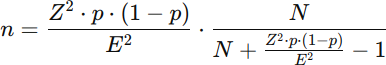

In [23]:
# Definindo os parâmetros
Z = 2.576  # valor Z 2.576 para 99% de confiança e Z 1.96 para 95% de IC
p = 0.5    # proporção estimada
E = 0.04   # margem de erro
N = 24580000  # tamanho da população

# Fórmula para o cálculo do tamanho da amostra para populações finitas
numerator = (Z**2 * p * (1 - p))
denominator = E**2
n_0 = numerator / denominator  # tamanho da amostra infinita
#n = n_0 / (1 + (n_0 - 1) / N)  # tamanho da amostra finita
n = n_0 * N /(N + ((Z**2*(1-p))/E**2) -1) # tamanho da amostra finita

# Exibindo os resultados
print(f"Tamanho da amostra necessário (n): {round(n)}")
print(f"Intervalo de Confiança (IC): {95 if Z == 1.96 else 99 if Z == 2.576 else 'Desconhecido'}%")
print(f"Margem de erro (E): {E * 100}%")
#print(n_0)

Tamanho da amostra necessário (n): 1037
Intervalo de Confiança (IC): 99%
Margem de erro (E): 4.0%


## Top 5 doenças relacionados ao trabalho

In [24]:
df_5 = pd.DataFrame(df_sp['DIAG_ESP'].str.slice(0, 3).value_counts().head(10))
df_5.reset_index(inplace=True)
df_5.columns=['DIAG_ESP','QTD']

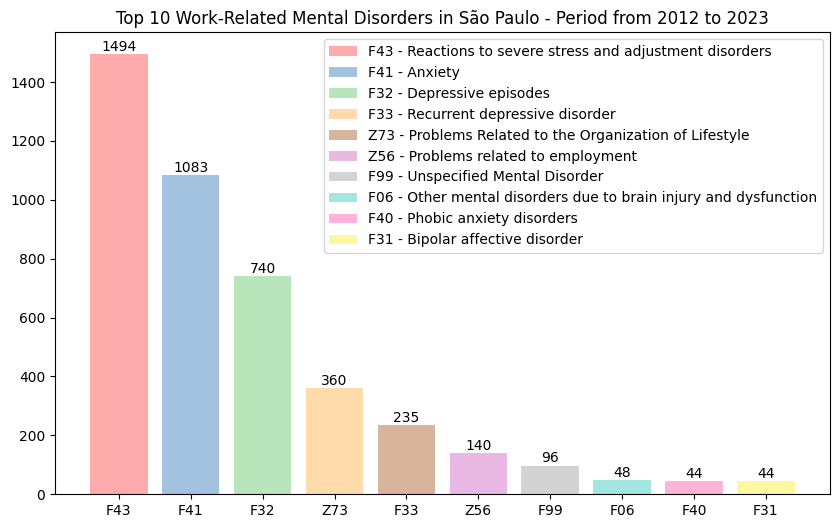

In [25]:
cores = [
    '#FFABAB',  '#A2C2E0',  '#B8E5B9',  '#FFDAAA',  '#D7B49B',
    '#EAB8E4',  '#D3D3D3',  '#A1E7E0',  '#FFB3D9',  '#FFF6A0'
]

"""legendas = ['F43 - Reações ao stress grave e transtornos de adaptação',
            'F41 - Ansiedade',
            'F32 - Episódios depressivos',
            'F33 - Transtorno depressivo recorrente',
            'Z73 - Problemas relacionados com a organização de seu modo de vida',
            'Z56 - Problemas relacionados com o emprego',
            'F99 - Transtorno mental não especificado',
            'F06 - Outros transtornos mentais devidos a lesão e disfunção cerebral',
            'F40 - Transtornos fóbico-ansiosos',
            'F31 - Transtorno afetivo bipolar']
"""

legendas = [
    'F43 - Reactions to severe stress and adjustment disorders',
    'F41 - Anxiety',
    'F32 - Depressive episodes',
    'F33 - Recurrent depressive disorder',
    'Z73 - Problems Related to the Organization of Lifestyle',
    'Z56 - Problems related to employment',
    'F99 - Unspecified Mental Disorder',
    'F06 - Other mental disorders due to brain injury and dysfunction',
    'F40 - Phobic anxiety disorders',
    'F31 - Bipolar affective disorder'
]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Work-Related Mental Disorders in São Paulo - Period from 2012 to 2023')
barras = plt.bar(df_5['DIAG_ESP'], df_5['QTD'], color=cores)
for barra, legenda in zip(barras, legendas):
    barra.set_label(legenda)

# Adicionando os valores de cada barra
for bar in barras:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval, 2), ha='center', va='bottom')

plt.legend(loc='best')
plt.show()


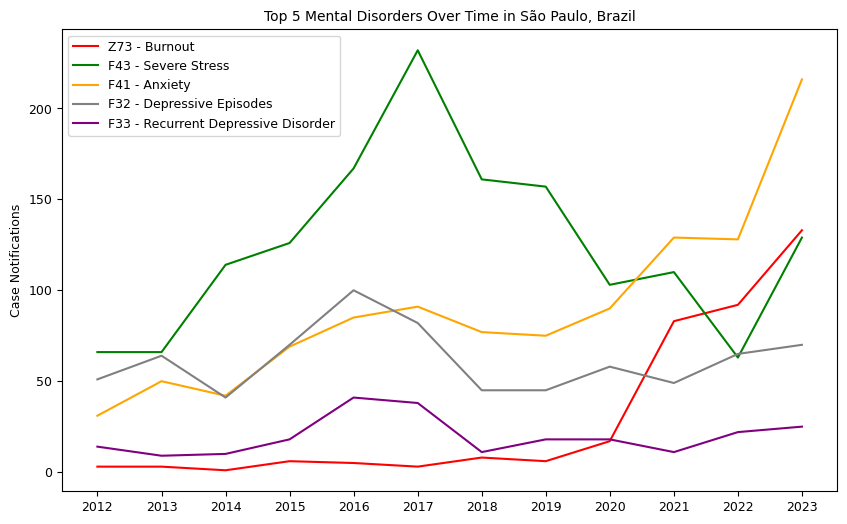

In [26]:
df_b = df_sp[df_sp['DIAG_ESP'].str.startswith('Z73')  & ~df_sp['DIAG_ESP'].isna()].copy()
df_s = df_sp[df_sp['DIAG_ESP'].str.startswith('F43')  & ~df_sp['DIAG_ESP'].isna()].copy()
df_a = df_sp[df_sp['DIAG_ESP'].str.startswith('F41')  & ~df_sp['DIAG_ESP'].isna()].copy()
df_d = df_sp[df_sp['DIAG_ESP'].str.startswith('F32')  & ~df_sp['DIAG_ESP'].isna()].copy()
df_dr = df_sp[df_sp['DIAG_ESP'].str.startswith('F33')  & ~df_sp['DIAG_ESP'].isna()].copy()
#Transformar em MesAno e Ano
s_mesano, s_ano = transf_mes_ano(df_sp)
s_mesano_b, s_ano_b = transf_mes_ano(df_b)
s_mesano_s, s_ano_s = transf_mes_ano(df_s)
s_mesano_a, s_ano_a = transf_mes_ano(df_a)
s_mesano_d, s_ano_d = transf_mes_ano(df_d)
s_mesano_dr, s_ano_dr = transf_mes_ano(df_dr)
plt.figure(figsize=(10, 6))
s_ano_b_resampled = s_ano_b.reindex(s_ano.index)
#plt.plot(s_ano,color='blue', label='Transtornos Mentais')
plt.plot(s_ano_b, color='red', label='Z73 - Burnout')
plt.plot(s_ano_s, color='green', label='F43 - Severe Stress')
plt.plot(s_ano_a, color='orange', label='F41 - Anxiety')
plt.plot(s_ano_d, color='gray', label='F32 - Depressive Episodes')
plt.plot(s_ano_dr, color='purple', label='F33 - Recurrent Depressive Disorder')
#plt.fill_between(s_ano.index, s_ano, s_ano_b_resampled, color='gray', alpha=0.3)  # Preenchimento entre as duas linhas
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().tick_params(axis='x', labelsize=9)
plt.gca().tick_params(axis='y', labelsize=9)
plt.legend(loc='best', fontsize=9)
plt.title('Top 5 Mental Disorders Over Time in São Paulo, Brazil', fontsize=10)  # Ajuste o título conforme necessário
plt.xlabel('', fontsize=9)
plt.ylabel('Case Notifications', fontsize=9)

plt.show()

## Taxa de Ansiedade Brasil

In [27]:
df_pop_br = df_pop[df_pop['UF'] == 'BR'].melt(id_vars=['UF', 'CODIGO_IBGE'], var_name='ANO', value_name='POPULACAO')
df_pop_br.drop(columns=['UF', 'CODIGO_IBGE'], inplace=True)
df_pop_br['ANO'] = df_pop_br['ANO'].astype(int)

df_anual = df_a.groupby(['ANO']).size().reset_index(name='count')
df_anual.columns = ['ANO', 'QTD']
df_anual['ANO'] = df_anual['ANO'].dt.year.astype(int)

df_anual = pd.merge(df_pop_br, df_anual, on=['ANO'], how='right')
df_anual['TAXA_ANSIEDADE'] = (df_anual['QTD'] / df_anual['POPULACAO']) * 100000


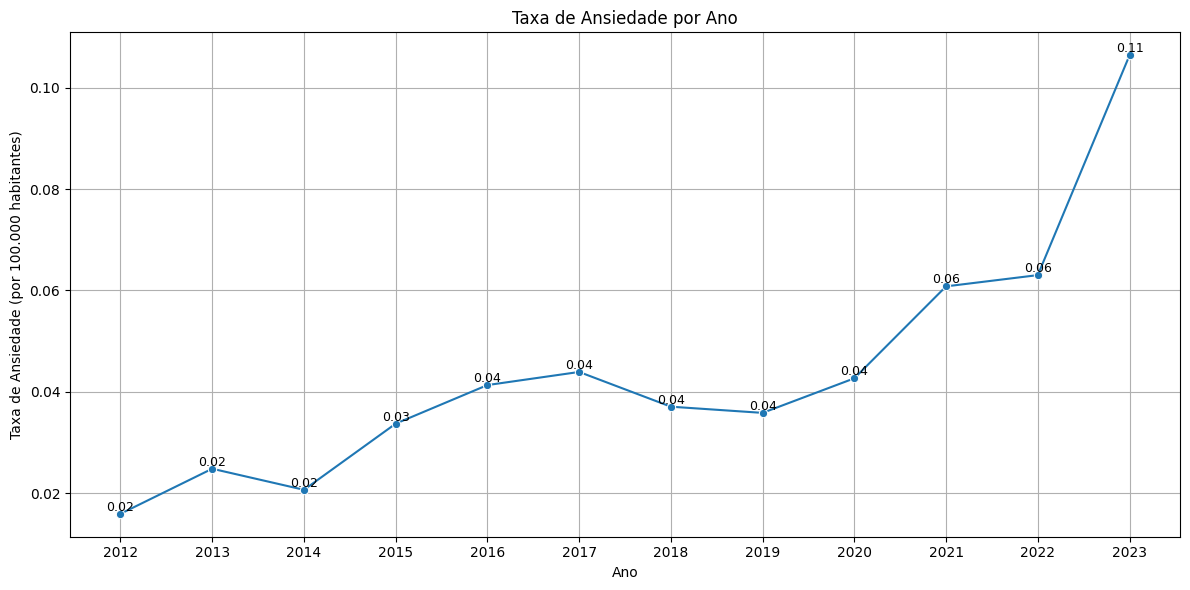

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_anual, x='ANO', y='TAXA_ANSIEDADE', marker='o')

# Adicionando rótulos às taxas
for index, row in df_anual.iterrows():
    plt.text(row['ANO'], row['TAXA_ANSIEDADE'], f"{row['TAXA_ANSIEDADE']:.2f}",
             horizontalalignment='center', verticalalignment='bottom', fontsize=9)

# Configurando título e rótulos dos eixos
plt.title('Taxa de Ansiedade por Ano')
plt.xlabel('Ano')
plt.ylabel('Taxa de Ansiedade (por 100.000 habitantes)')
#plt.xticks(rotation=45)
plt.xticks(df_anual['ANO'].unique())
plt.grid()
plt.tight_layout()
plt.show()

## Tendência da Ansiedade-DRT em SP

In [29]:
df_trimestral_sp = df_sp.groupby(pd.Grouper(freq='Q', level=0)).size().reset_index(name='QTD')

# Alterando a data para o primeiro dia do último mês do trimestre
df_trimestral_sp['TRIMESTRE'] = df_trimestral_sp['DT_NOTIFIC'].dt.to_period('Q').dt.end_time

# Caso deseje manter apenas a data sem a hora
df_trimestral_sp['TRIMESTRE'] = df_trimestral_sp['TRIMESTRE'].dt.normalize()

df_trimestral_sp['TRIMESTRE'] = df_trimestral_sp['TRIMESTRE'].dt.to_period('M').dt.start_time

df_trimestral_sp['ANO'] = df_trimestral_sp['TRIMESTRE'].dt.year

df_trimestral_sp = pd.merge(df_empregos, df_trimestral_sp, on=['TRIMESTRE'], how='right')
df_trimestral_sp['TAXA_TRANSTORNO'] = (df_trimestral_sp['QTD'] / df_trimestral_sp['QTD_OCUPADOS']) * 100000

df_trimestral_sp['QTD_OCUPADOS'] = df_trimestral_sp['QTD_OCUPADOS'].astype(int)


In [30]:

df_ansiedade = df_sp[df_sp['DIAG_ESP'].str.startswith('F41') & ~df_sp['DIAG_ESP'].isna()].copy()
df_ansiedade = df_ansiedade.groupby(pd.Grouper(freq='Q', level=0)).size().reset_index(name='QTD')

df_ansiedade['TRIMESTRE'] = df_ansiedade['DT_NOTIFIC'].dt.to_period('Q').dt.end_time

df_ansiedade['TRIMESTRE'] = df_ansiedade['TRIMESTRE'].dt.normalize()

df_ansiedade['TRIMESTRE'] = df_ansiedade['TRIMESTRE'].dt.to_period('M').dt.start_time

df_ansiedade['ANO'] = df_ansiedade['TRIMESTRE'].dt.year

df_ansiedade = pd.merge(df_empregos, df_ansiedade, on=['TRIMESTRE'], how='right')
df_ansiedade['TAXA_ANSIEDADE'] = (df_ansiedade['QTD'] / df_ansiedade['QTD_OCUPADOS']) * 100000

df_ansiedade['QTD_OCUPADOS'] = df_ansiedade['QTD_OCUPADOS'].astype(int)

df_ansiedade.drop(columns=['QTD_OCUPADOS'], inplace=True)

df_trimestral_sp = pd.merge(df_trimestral_sp, df_ansiedade[['TRIMESTRE', 'TAXA_ANSIEDADE']], on='TRIMESTRE', how='left')

In [31]:
df_anual_sp = df_trimestral_sp.groupby('ANO').agg({
    'QTD_OCUPADOS': 'sum',
    'QTD': 'sum',
    'TAXA_TRANSTORNO': 'mean',
    'TAXA_ANSIEDADE': 'mean'
}).reset_index()

In [32]:
df_anual_sp

,ANO,QTD_OCUPADOS,QTD,TAXA_TRANSTORNO,TAXA_ANSIEDADE
0,2012,84250000,198,0.235175,0.036910
1,2013,85690000,244,0.284902,0.058407
2,2014,86118000,240,0.278980,0.048791
3,2015,85984000,317,0.368763,0.080330
4,2016,85718000,513,0.598435,0.099104
5,2017,86878000,524,0.603248,0.104779
6,2018,88365000,490,0.554792,0.086991
7,2019,90950000,537,0.589531,0.082098
8,2020,83028000,339,0.403552,0.107000
9,2021,87567000,484,0.555328,0.147331


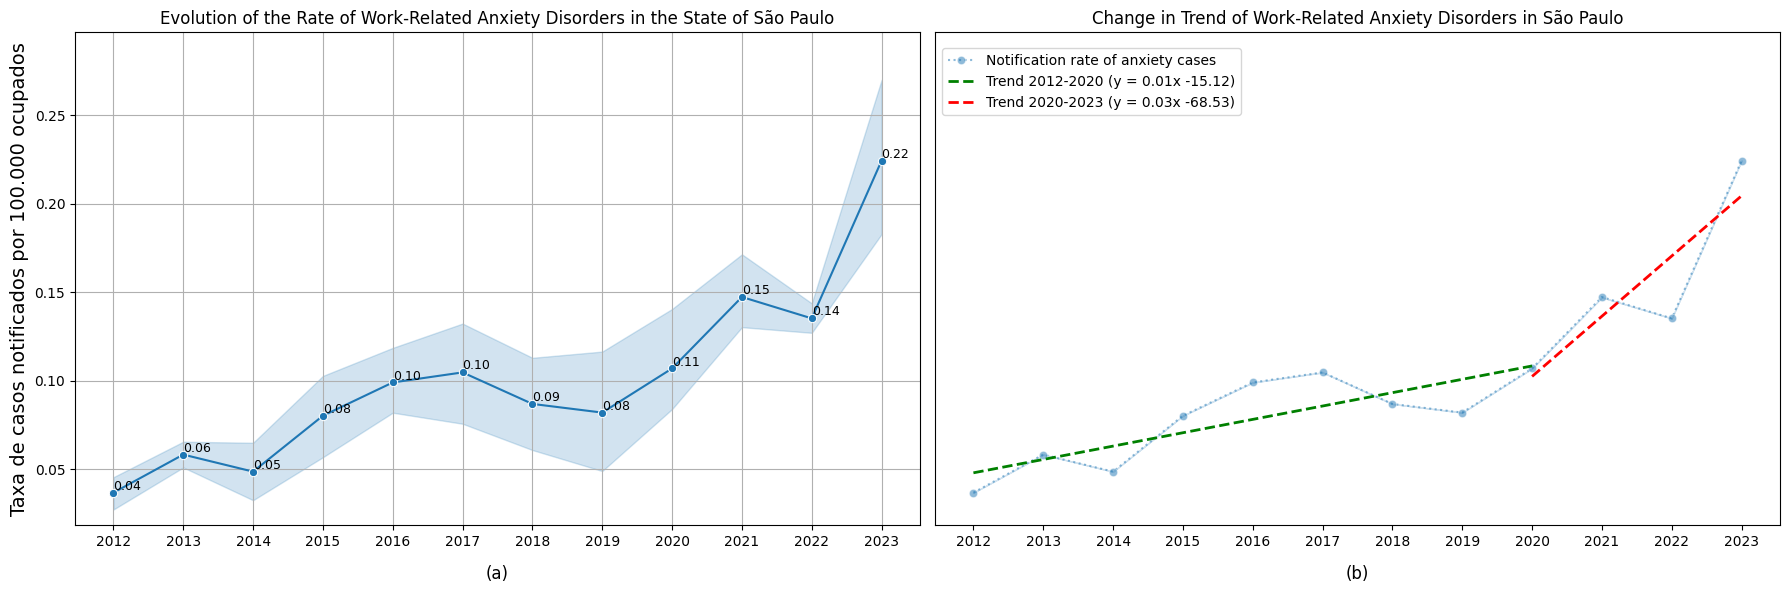

In [33]:
# Configuração da figura e dos eixos (subplots) lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 linha e 2 colunas

# Subplot 1: Taxa de Ansiedade com rótulos
sns.lineplot(data=df_trimestral_sp, x='ANO', y='TAXA_ANSIEDADE', marker='o', label='Taxa de Ansiedade', ci=90, ax=axes[0])

# Configurações do gráfico 1
axes[0].set_title('Evolution of the Rate of Work-Related Anxiety Disorders in the State of São Paulo', fontsize=12)
axes[0].set_xlabel('', fontsize=14)
#axes[0].set_ylabel('Notified Cases Rate per 100,000 Workers', fontsize=14)
axes[0].set_ylabel('Taxa de casos notificados por 100.000 ocupados', fontsize=14)
axes[0].grid()
axes[0].legend('', frameon=False)
axes[0].set_xticks(df_trimestral_sp['ANO'].unique())
axes[0].tick_params(axis='x', rotation=0)

# Adicionando rótulos às taxas
for index, row in df_anual_sp.iterrows():
    axes[0].text(row['ANO'], row['TAXA_ANSIEDADE'], f"{row['TAXA_ANSIEDADE']:.2f}",
                 horizontalalignment='left', verticalalignment='bottom', fontsize=9)

# Subplot 2: Mudança na tendência com regressões
sns.lineplot(data=df_trimestral_sp, x='ANO', y='TAXA_ANSIEDADE', marker='o', ci=0, label='Notification rate of anxiety cases', alpha=0.5, linestyle=':', ax=axes[1])

# Configurações do gráfico 2
axes[1].set_title('Change in Trend of Work-Related Anxiety Disorders in São Paulo', fontsize=12)
axes[1].set_xlabel('', fontsize=14)
axes[1].set_ylabel('', fontsize=14)
axes[1].grid(False)
axes[1].legend('', frameon=False)
axes[1].set_xticks(df_trimestral_sp['ANO'].unique())
axes[1].set_yticks([])
axes[1].tick_params(axis='x', rotation=0)

# Segment 1: 2012 a 2019
mask1 = (df_trimestral_sp['ANO'] >= 2012) & (df_trimestral_sp['ANO'] <= 2020)
x1 = df_trimestral_sp['ANO'][mask1]
y1 = df_trimestral_sp['TAXA_ANSIEDADE'][mask1]

# Ajuste da linha de regressão para o primeiro segmento
coef1 = np.polyfit(x1, y1, 1)  # Ajuste linear (grau 1)
poly1 = np.poly1d(coef1)
axes[1].plot(x1, poly1(x1), color='green', linestyle='--', label=f'Trend 2012-2020 (y = {coef1[0]:.2f}x {coef1[1]:.2f})', linewidth=2)

# Segment 2: 2019 a 2023
mask2 = (df_trimestral_sp['ANO'] > 2019) & (df_trimestral_sp['ANO'] <= 2023)
x2 = df_trimestral_sp['ANO'][mask2]
y2 = df_trimestral_sp['TAXA_ANSIEDADE'][mask2]

# Ajuste da linha de regressão para o segundo segmento
coef2 = np.polyfit(x2, y2, 1)  # Ajuste linear (grau 1)
poly2 = np.poly1d(coef2)
axes[1].plot(x2, poly2(x2), color='red', linestyle='--', label=f'Trend 2020-2023 (y = {coef2[0]:.2f}x {coef2[1]:.2f})', linewidth=2)

# Adiciona a legenda ao gráfico 2
axes[1].legend(loc='center left', bbox_to_anchor=(0, 0.9))  # Ajustar a posição com bbox_to_anchor

# Define a mesma escala no eixo Y para ambos os gráficos
y_min = min(df_trimestral_sp['TAXA_ANSIEDADE'])
y_max = max(df_trimestral_sp['TAXA_ANSIEDADE'])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Adicionando letras (a) e (b) abaixo dos gráficos
axes[0].text(0.5, -0.1, '(a)', fontsize=12, ha='center', va='center', transform=axes[0].transAxes)
axes[1].text(0.5, -0.1, '(b)', fontsize=12, ha='center', va='center', transform=axes[1].transAxes)

# Ajusta o layout da figura
plt.tight_layout()
plt.show()


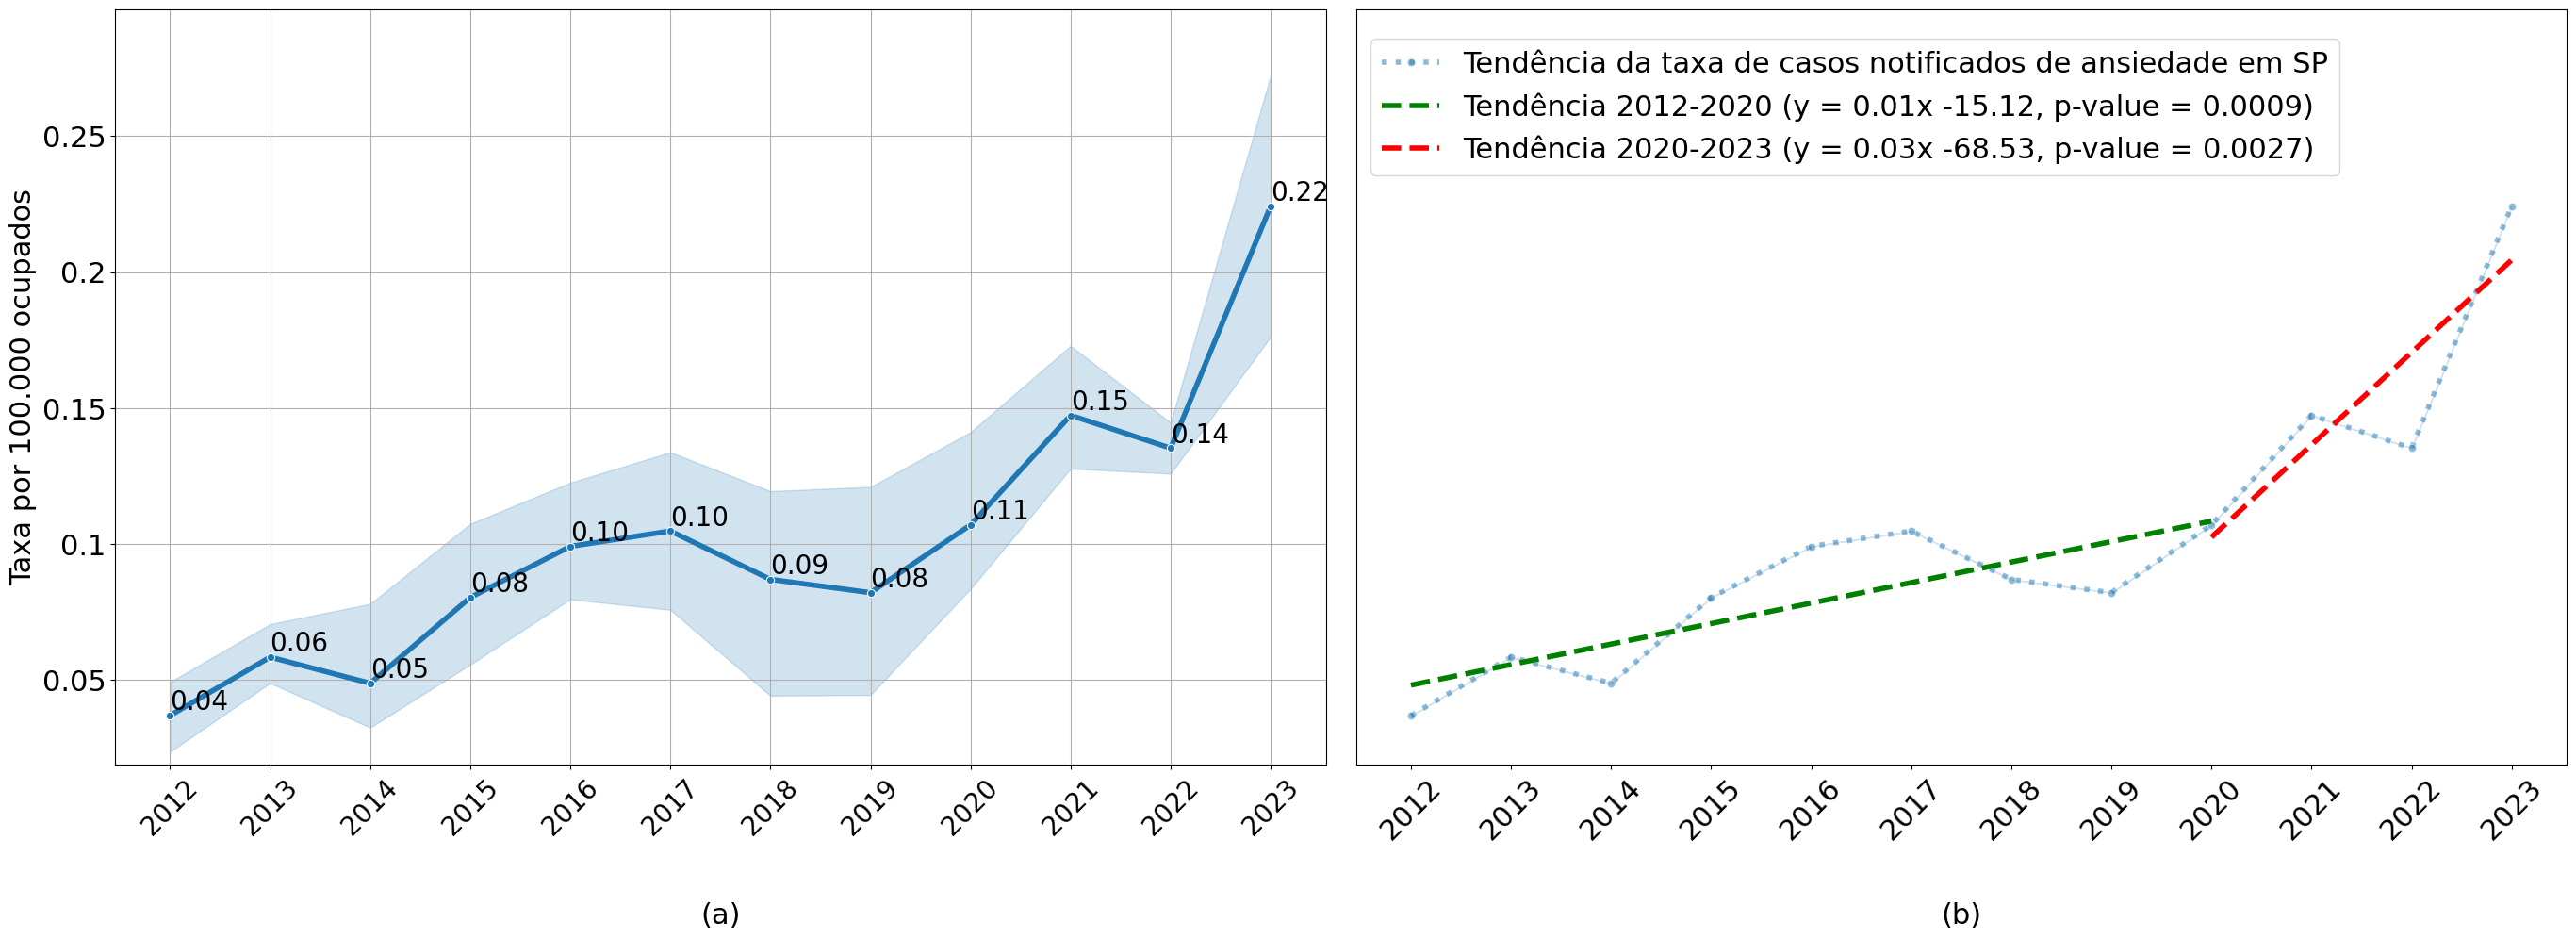

In [34]:
%matplotlib inline
from scipy.stats import linregress

# Configuração da figura e dos eixos (subplots) lado a lado
fig, axes = plt.subplots(1, 2, figsize=(28, 10))  # 1 linha e 2 colunas

# Subplot 1: Taxa de Ansiedade com rótulos
sns.lineplot(data=df_trimestral_sp, x='ANO', y='TAXA_ANSIEDADE', marker='o', label='Taxa de Ansiedade', ci=95, ax=axes[0],linewidth=4)

# Configurações do gráfico 1
axes[0].set_title('', fontsize=20)
axes[0].set_xlabel('', fontsize=20)
axes[0].set_ylabel('Taxa por 100.000 ocupados', fontsize=22)
axes[0].set_yticklabels(axes[0].get_yticks().round(2), fontsize=22)
axes[0].grid()
axes[0].legend('', frameon=False)
axes[0].set_xticks(df_trimestral_sp['ANO'].unique())
axes[0].set_xticklabels(df_trimestral_sp['ANO'].unique(), fontsize=20)
axes[0].tick_params(axis='x', rotation=45)

# Adicionando rótulos às taxas
for index, row in df_anual_sp.iterrows():
    axes[0].text(row['ANO'], row['TAXA_ANSIEDADE'], f"{row['TAXA_ANSIEDADE']:.2f}",
                 horizontalalignment='left', verticalalignment='bottom', fontsize=20)

# Subplot 2: Mudança na tendência com regressões
sns.lineplot(data=df_trimestral_sp, x='ANO', y='TAXA_ANSIEDADE', marker='o', ci=0, label='Tendência da taxa de casos notificados de ansiedade em SP', alpha=0.5, linestyle=':', ax=axes[1],linewidth=4)

axes[1].set_title('', fontsize=22)
axes[1].set_xlabel('', fontsize=22)
axes[1].set_ylabel('', fontsize=22)
axes[1].grid(False)
axes[1].legend('', frameon=False)
axes[1].set_xticks(df_trimestral_sp['ANO'].unique())
axes[1].set_xticklabels(df_trimestral_sp['ANO'].unique(), fontsize=22)
axes[1].set_yticks([])
axes[1].tick_params(axis='x', rotation=45)

# Segment 1: 2012 a 2020
mask1 = (df_trimestral_sp['ANO'] >= 2012) & (df_trimestral_sp['ANO'] <= 2020)
x1 = df_trimestral_sp['ANO'][mask1]
y1 = df_trimestral_sp['TAXA_ANSIEDADE'][mask1]

# Ajuste da linha de regressão para o primeiro segmento usando linregress
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(x1, y1)
axes[1].plot(x1, intercept1 + slope1 * x1, color='green', linestyle='--',
             label=f'Tendência 2012-2020 (y = {slope1:.2f}x {intercept1:.2f}, p-value = {p_value1:.4f})', linewidth=4)

# Segment 2: 2020 a 2023
mask2 = (df_trimestral_sp['ANO'] > 2019) & (df_trimestral_sp['ANO'] <= 2023)
x2 = df_trimestral_sp['ANO'][mask2]
y2 = df_trimestral_sp['TAXA_ANSIEDADE'][mask2]

# Ajuste da linha de regressão para o segundo segmento usando linregress
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x2, y2)
axes[1].plot(x2, intercept2 + slope2 * x2, color='red', linestyle='--',
             label=f'Tendência 2020-2023 (y = {slope2:.2f}x {intercept2:.2f}, p-value = {p_value2:.4f})', linewidth=4)

# Adiciona a legenda ao gráfico 2
axes[1].legend(loc='center left', bbox_to_anchor=(0, 0.87), fontsize=22)  # Ajustar a posição com bbox_to_anchor

# Define a mesma escala no eixo Y para ambos os gráficos
y_min = min(df_trimestral_sp['TAXA_ANSIEDADE'])
y_max = max(df_trimestral_sp['TAXA_ANSIEDADE'])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

# Adicionando letras (a) e (b) abaixo dos gráficos
axes[0].text(0.5, -0.2, '(a)', fontsize=22, ha='center', va='center', transform=axes[0].transAxes)
axes[1].text(0.5, -0.2, '(b)', fontsize=22, ha='center', va='center', transform=axes[1].transAxes)

# Ajusta o layout da figura
plt.tight_layout()
plt.show()


In [35]:
from scipy import stats

# Suponha que você tenha suas taxas de ansiedade em dois arrays:
taxa_2012_2019 = df_trimestral_sp['TAXA_ANSIEDADE'][(df_trimestral_sp['ANO'] >= 2012) & (df_trimestral_sp['ANO'] <= 2019)]
taxa_2020_2023 = df_trimestral_sp['TAXA_ANSIEDADE'][(df_trimestral_sp['ANO'] > 2019) & (df_trimestral_sp['ANO'] <= 2023)]

# Realizando o teste t
t_statistic, p_value = stats.ttest_ind(taxa_2012_2019, taxa_2020_2023)
print(f'T-statistic: {t_statistic}, P-value: {p_value}')


T-statistic: -5.860815376046473, P-value: 4.6794473483185297e-07


In [36]:
from scipy.stats import f_oneway

# Realizando ANOVA
ano_groups = [df_trimestral_sp['TAXA_ANSIEDADE'][df_trimestral_sp['ANO'] == ano] for ano in df_trimestral_sp['ANO'].unique()]
f_statistic, p_value_anova = f_oneway(*ano_groups)
print(f'F-statistic: {f_statistic}, P-value (ANOVA): {p_value_anova}')

F-statistic: 8.77106128086332, P-value (ANOVA): 2.7427869344561505e-07


In [37]:
'''df_anual_uf = df_a.groupby(['ANO', 'UF']).size().reset_index(name='count')
df_anual_uf.columns = ['ANO', 'UF', 'QTD']
df_pop2 = df_pop.melt(id_vars=['UF', 'CODIGO_IBGE'], var_name='ANO', value_name='POPULACAO')
df_pop2['ANO'] = df_pop2['ANO'].astype(int)

df_anual_uf['ANO'] = df_anual_uf['ANO'].dt.year.astype(int)
df_anual_uf = pd.merge(df_pop2, df_anual_uf, on=['ANO', 'UF'], how='right')
df_anual_uf['TAXA_ANSIEDADE'] = (df_anual_uf['QTD'] / df_anual_uf['POPULACAO']) * 100000
'''

"df_anual_uf = df_a.groupby(['ANO', 'UF']).size().reset_index(name='count')\ndf_anual_uf.columns = ['ANO', 'UF', 'QTD']\ndf_pop2 = df_pop.melt(id_vars=['UF', 'CODIGO_IBGE'], var_name='ANO', value_name='POPULACAO')\ndf_pop2['ANO'] = df_pop2['ANO'].astype(int)\n\ndf_anual_uf['ANO'] = df_anual_uf['ANO'].dt.year.astype(int)\ndf_anual_uf = pd.merge(df_pop2, df_anual_uf, on=['ANO', 'UF'], how='right')\ndf_anual_uf['TAXA_ANSIEDADE'] = (df_anual_uf['QTD'] / df_anual_uf['POPULACAO']) * 100000\n"

## Análise de Ocupação e Área econômica

In [38]:
df_ocup1 = pd.DataFrame(df_sp_a1[['ID_OCUPA_N','PROFISSAO','AREA']].value_counts())
#df_10_ocup = pd.DataFrame(df_sp2['ID_OCUPA_N'].value_counts())
df_ocup1.reset_index(inplace=True)
df_ocup1.columns=['ID_OCUPA_N','PROFISSAO','AREA','QTD']


df_ocup2 = pd.DataFrame(df_sp_a2[['ID_OCUPA_N','PROFISSAO','AREA']].value_counts())
#df_10_ocup = pd.DataFrame(df_sp2['ID_OCUPA_N'].value_counts())
df_ocup2.reset_index(inplace=True)
df_ocup2.columns=['ID_OCUPA_N','PROFISSAO','AREA','QTD']


df_ocup3 = pd.DataFrame(df_sp_a[['ID_OCUPA_N','PROFISSAO','AREA']].value_counts())
#df_10_ocup = pd.DataFrame(df_sp2['ID_OCUPA_N'].value_counts())
df_ocup3.reset_index(inplace=True)
df_ocup3.columns=['ID_OCUPA_N','PROFISSAO','AREA','QTD']

In [39]:
'''
1417 - Gerentes de operações de serviços em instituição de intermediação financeira
2532 - Profissionais de comercializacão e consultoria de serviços bancários
4110 - Agentes, assistentes e auxiliares administrativos
4132 - Escriturários de serviços bancários
3222 - Técnicos e auxiliares de enfermagem
5142 - Trabalhadores nos serviços de coleta de resíduos, de limpeza e conservação de áreas públicas
5211 - Operadores do comércio em lojas e mercados
4223 - Operadores de telemarketing e afins
9989 - Ignorado
7842 - Alimentadores de linhas de produção
2235 - Enfermeiros e afins
'''
print(df_ocup1['QTD'].sum())
print(df_ocup2['QTD'].sum())
print(df_ocup3['QTD'].sum())

520
563
1083


In [40]:
#df_10_ocup2 = df_10_ocup.merge(df_ocupacao, on='ID_OCUPA_N', how='left')
#df_area['ID_OCUPA_N'] = df_area['ID_OCUPA_N'].astype(str).str[:4]
#df_area = df_area.groupby('ID_OCUPA_N')['AREA'].first().reset_index()
#df_10_ocup2 = df_10_ocup2.merge(df_area, on='ID_OCUPA_N', how='left')

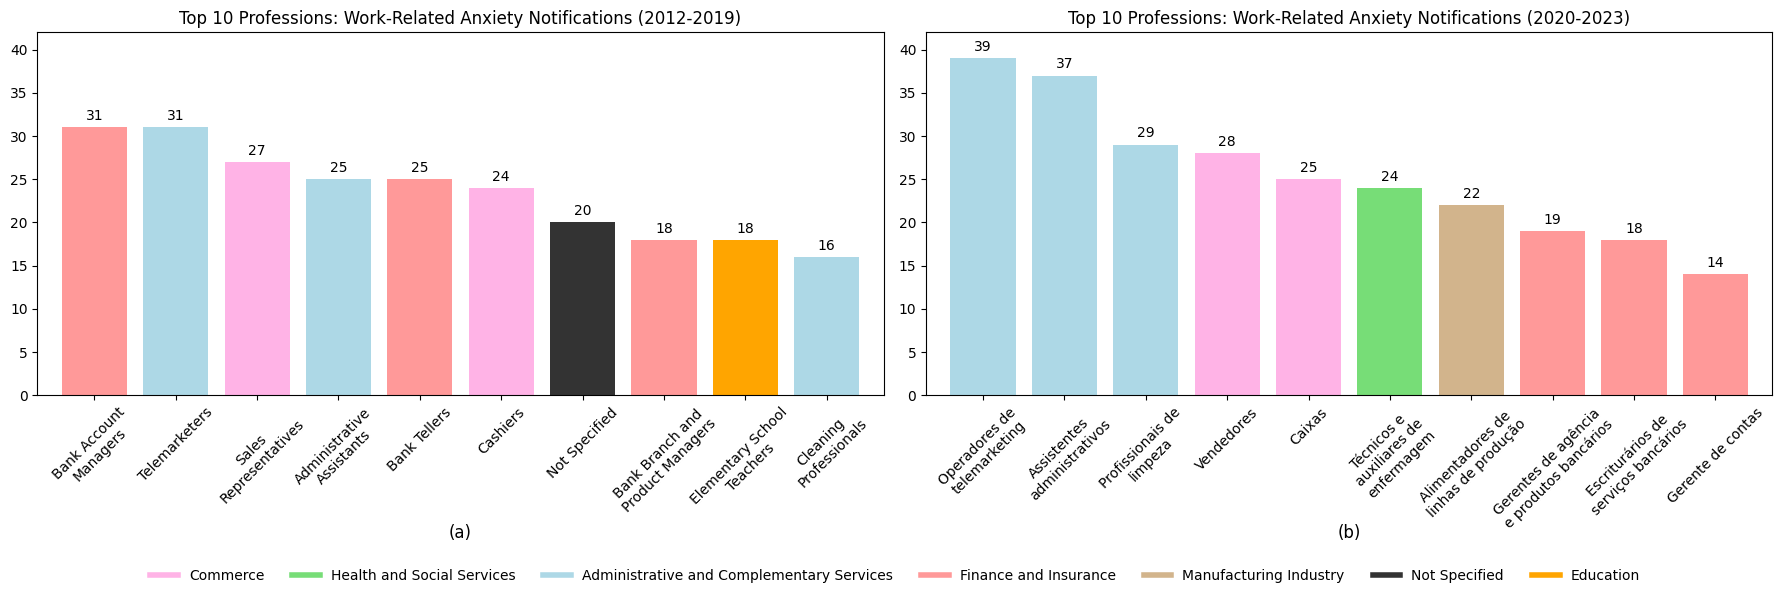

In [41]:
import textwrap
import matplotlib.pyplot as plt

# Dados para os gráficos
df_10_ocup1 = df_ocup1.head(10)  # Agora está usando df_ocup2 para o primeiro gráfico
df_10_ocup2 = df_ocup2.head(10)  # Agora está usando df_ocup1 para o segundo gráfico

# Definição de cores para as diferentes áreas
colors = {
    'Financeiro e Seguros': '#FF9999',  # Vermelho pastel mais claro
    'Administrativo e Serviços complementares': '#ADD8E6',  # Azul
    'Indústria de Transformação': '#D2B48C',  # Marrom pastel
    'Saúde e Serviços Sociais': '#77DD77',  # Verde mais escuro
    'Comércio': '#FFB3E6',  # Roxo pastel
    'Atividades Profissionais, Científicas e Técnicas': '#A9A9A9',  # Cinza
    'Não informado': '#333333',  # Preto
    'Educação': '#FFA500',  # Laranja
    'Transporte, Armazenagem e Correio': '#DDA0DD',  # Roxo
    'Alojamento e Alimentação': '#FFD700',  # Amarelo
}

#Legendas traduzidas
translation_dict = {
    'Financeiro e Seguros': 'Finance and Insurance',
    'Administrativo e Serviços complementares': 'Administrative and Complementary Services',
    'Indústria de Transformação': 'Manufacturing Industry',
    'Saúde e Serviços Sociais': 'Health and Social Services',
    'Comércio': 'Commerce',
    'Atividades Profissionais, Científicas e Técnicas': 'Professional, Scientific, and Technical Activities',
    'Não informado': 'Not Specified',
    'Educação': 'Education',
    'Transporte, Armazenagem e Correio': 'Transport and Logistics',
    'Alojamento e Alimentação': 'Accommodation and Food Services',
}

# Criando o layout com dois subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Top 10 Professions (2012-2019) - Agora usando df_ocup2
ax1.set_title('Top 10 Professions: Work-Related Anxiety Notifications (2012-2019)')
bars1 = ax1.bar(df_10_ocup1['PROFISSAO'], df_10_ocup1['QTD'], color=[colors[area] for area in df_10_ocup1['AREA']])

# Adicionando os valores de cada barra
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')


#Rotulos em ingles no eixo X
labels_en1 = [
    'Bank Account Managers',
    'Telemarketers',
    'Sales Representatives',
    'Administrative Assistants',
    'Bank Tellers',
    'Cashiers',
    'Not Specified',
    'Bank Branch and Product Managers',
    'Elementary School Teachers',
    'Cleaning Professionals',
]

# Define os rótulos do eixo x
#wrapped_labels1 = [textwrap.fill(label, width=20) for label in df_10_ocup1['PROFISSAO']]  # 20 caracteres por linha
wrapped_labels1 = [textwrap.fill(label, width=20) for label in labels_en1]
ax1.set_xticks(range(len(wrapped_labels1)))
ax1.set_xticklabels(wrapped_labels1, rotation=45, ha='center')
ax1.set_xlim(-0.7, len(wrapped_labels1) - 0.3)

# Gráfico 2: Top 10 Professions (2020-2023) - Agora usando df_ocup1
ax2.set_title('Top 10 Professions: Work-Related Anxiety Notifications (2020-2023)')
bars2 = ax2.bar(df_10_ocup2['PROFISSAO'], df_10_ocup2['QTD'], color=[colors[area] for area in df_10_ocup2['AREA']])

# Adicionando os valores de cada barra
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')


#Rotulos em ingles no eixo X
labels_en2 = [
    'Telemarketers',
    'Administrative Assistants',
    'Cleaning Professionals',
    'Sales Representatives',
    'Cashiers',
    'Nursing Technicians and Assistants',
    'Production Line Feeders',
    'Bank Branch and Product Managers',
    'Bank Tellers',
    'Bank Account Managers'
]

# Define os rótulos do eixo x
wrapped_labels2 = [textwrap.fill(label, width=20) for label in df_10_ocup2['PROFISSAO']]  # 20 caracteres por linha
#wrapped_labels2 = [textwrap.fill(label, width=20) for label in labels_en2]
ax2.set_xticks(range(len(wrapped_labels2)))
ax2.set_xticklabels(wrapped_labels2, rotation=45, ha='center')
ax2.set_xlim(-0.7, len(df_10_ocup2['PROFISSAO']) - 0.3)

# Ajusta os limites do eixo Y
max_y1 = df_10_ocup1['QTD'].max()  # valor máximo de y para o primeiro gráfico
max_y2 = df_10_ocup2['QTD'].max()  # valor máximo de y para o segundo gráfico
ax1.set_ylim(0, max(max_y1, max_y2) + 3)  # Aumentar limite do eixo Y
ax2.set_ylim(0, max(max_y1, max_y2) + 3)

# Criar uma lista única de áreas que aparecem nos gráficos
areas1 = df_10_ocup1['AREA'].unique()
areas2 = df_10_ocup2['AREA'].unique()
unique_areas = set(areas1).union(set(areas2))  # Conjunta as áreas de ambos os gráficos

# Filtrar cores e legendas com base nas áreas únicas
handles = [plt.Line2D([0], [0], color=colors[area], lw=4) for area in unique_areas if area in colors]
labels = [translation_dict[area] for area in unique_areas if area in colors]

# Adiciona a legenda única abaixo dos gráficos sem borda
fig.legend(handles, labels, title='', loc='lower center', bbox_to_anchor=(0.5, -0.0), ncol=7, frameon=False)

# Adicionando letras (a) e (b) abaixo dos gráficos
ax1.text(0.5, -0.38, '(a)', fontsize=12, ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, -0.38, '(b)', fontsize=12, ha='center', va='center', transform=ax2.transAxes)

plt.tight_layout()  # Ajusta os subplots para que eles não se sobreponham
plt.show()


In [42]:
df_10_ocup2

,ID_OCUPA_N,PROFISSAO,AREA,QTD
0,4223,Operadores de telemarketing,Administrativo e Serviços complementares,39
1,4110,Assistentes administrativos,Administrativo e Serviços complementares,37
2,5142,Profissionais de limpeza,Administrativo e Serviços complementares,29
3,5211,Vendedores,Comércio,28
4,4211,Caixas,Comércio,25
5,3222,Técnicos e auxiliares de enfermagem,Saúde e Serviços Sociais,24
6,7842,Alimentadores de linhas de produção,Indústria de Transformação,22
7,1417,Gerentes de agência e produtos bancários,Financeiro e Seguros,19
8,4132,Escriturários de serviços bancários,Financeiro e Seguros,18
9,2532,Gerente de contas,Financeiro e Seguros,14


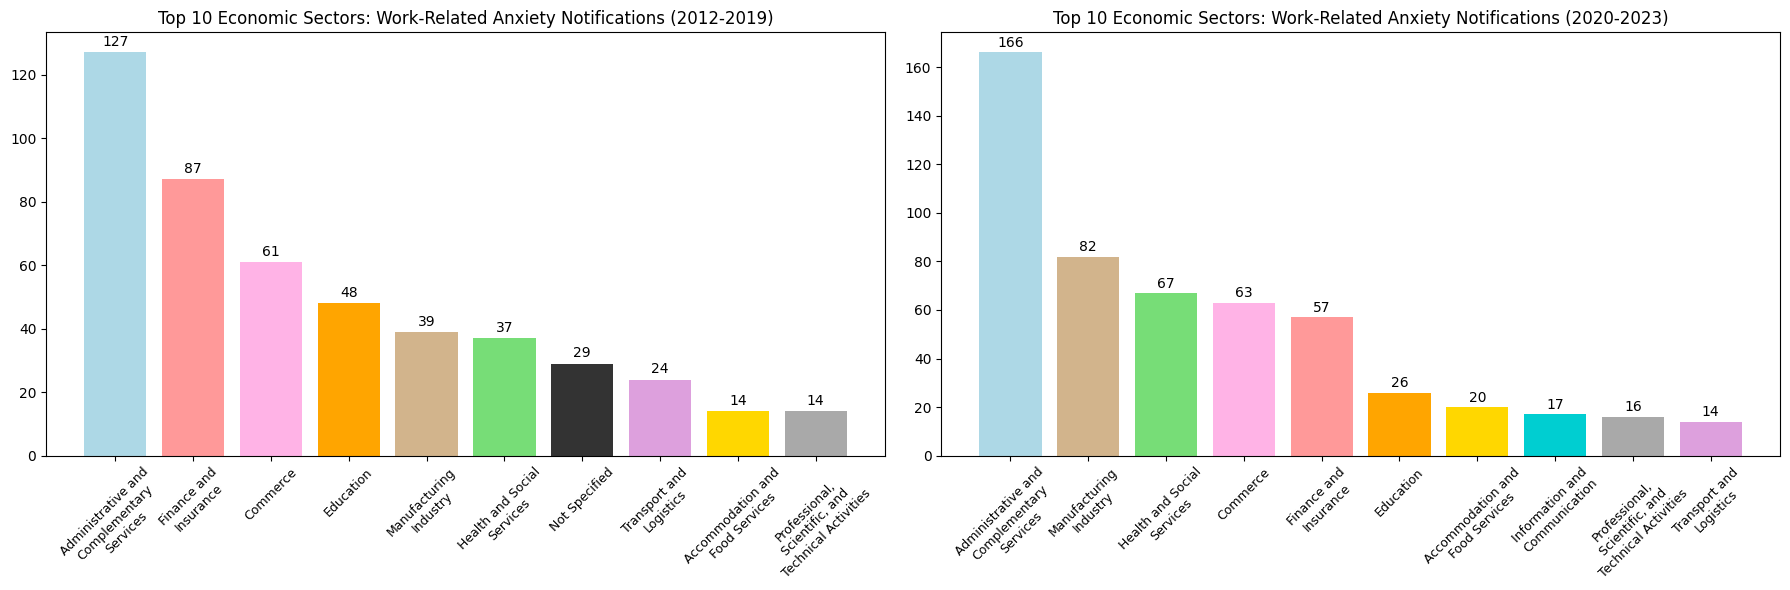

In [43]:
import textwrap
import matplotlib.pyplot as plt

# Agrupar e calcular o total de notificações para os dois DataFrames
df10_area1 = df_ocup1.groupby('AREA').agg({'QTD': 'sum'}).sort_values(by='QTD', ascending=False).head(10).reset_index()
df10_area2 = df_ocup2.groupby('AREA').agg({'QTD': 'sum'}).sort_values(by='QTD', ascending=False).head(10).reset_index()

# Definir as cores para os diferentes setores
colors = {
    'Financeiro e Seguros': '#FF9999',  # Vermelho pastel mais claro
    'Administrativo e Serviços complementares': '#ADD8E6',  # Azul
    'Indústria de Transformação': '#D2B48C',  # Marrom pastel
    'Saúde e Serviços Sociais': '#77DD77',  # Verde mais escuro
    'Comércio': '#FFB3E6',  # Roxo pastel
    'Atividades Profissionais, Científicas e Técnicas': '#A9A9A9',  # Cinza
    'Educação': '#FFA500',  # Laranja
    'Transporte, Armazenagem e Correio': '#DDA0DD',  # Roxo
    'Alojamento e Alimentação': '#FFD700',  # Amarelo
    'Informação e Comunicação': '#00CED1',  # Azul claro
    'Outras Atividades de Serviços': '#FFCC99',  # Laranja claro
    'Não informado': '#333333',  # Preto
    'Administração Pública e Defesa': '#FF4500',  # Laranja
    'Serviços Domésticos': '#FFC0CB',  # Rosa claro suave
    'Construção': '#00BFFF',  # Ciano profundo
}

translation_dict = {
    'Financeiro e Seguros': 'Finance and Insurance',
    'Administrativo e Serviços complementares': 'Administrative and Complementary Services',
    'Indústria de Transformação': 'Manufacturing Industry',
    'Saúde e Serviços Sociais': 'Health and Social Services',
    'Comércio': 'Commerce',
    'Atividades Profissionais, Científicas e Técnicas': 'Professional, Scientific, and Technical Activities',
    'Não informado': 'Not Specified',
    'Educação': 'Education',
    'Transporte, Armazenagem e Correio': 'Transport and Logistics',
    'Alojamento e Alimentação': 'Accommodation and Food Services',
    'Informação e Comunicação': 'Information and Communication',
    'Outras Atividades de Serviços': 'Other Service Activities',
    'Administração Pública e Defesa': 'Public Administration and Defense',
    'Serviços Domésticos': 'Domestic Services',
    'Construção': 'Construction',
}

# Criando o layout com dois subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: df10_area1
ax1.set_title('Top 10 Economic Sectors: Work-Related Anxiety Notifications (2012-2019)')
bars1 = ax1.bar(df10_area1['AREA'], df10_area1['QTD'], color=[colors[area] for area in df10_area1['AREA']])

# Adicionando os valores de cada barra para o primeiro gráfico
total_notificacoes1 = df10_area1['QTD'].sum()
#for bar in bars1:
    #yval = bar.get_height()
    #percent_val = (yval / total_notificacoes1) * 100  # Cálculo da porcentagem
    #ax1.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{percent_val:.2f}%', ha='center', va='bottom')  # Exibindo em porcentagem
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom')  # Exibindo QTD

# Definindo os rótulos do eixo x com quebra de linha
translated_labels1 = [translation_dict[label] for label in df10_area1['AREA']]
wrapped_labels1 = [textwrap.fill(label, width=20) for label in translated_labels1]  # 20 caracteres por linha
#wrapped_labels1 = [textwrap.fill(label, width=20) for label in df10_area1['AREA']]  # 20 caracteres por linha
ax1.set_xticklabels(wrapped_labels1, rotation=45, ha='center', fontsize=9)

# Gráfico 2: df10_area2
ax2.set_title('Top 10 Economic Sectors: Work-Related Anxiety Notifications (2020-2023)')
bars2 = ax2.bar(df10_area2['AREA'], df10_area2['QTD'], color=[colors[area] for area in df10_area2['AREA']])

# Adicionando os valores de cada barra para o segundo gráfico
total_notificacoes2 = df10_area2['QTD'].sum()
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval}', ha='center', va='bottom')  # Exibindo QTD

# Definindo os rótulos do eixo x com quebra de linha
translated_labels2 = [translation_dict[label] for label in df10_area2['AREA']]
wrapped_labels2 = [textwrap.fill(label, width=20) for label in translated_labels2]  # 20 caracteres por linha
#wrapped_labels2 = [textwrap.fill(label, width=20) for label in df10_area2['AREA']]  # 20 caracteres por linha
ax2.set_xticklabels(wrapped_labels2, rotation=45, ha='center',fontsize=9, va='top')

# Ajustando o layout para não sobrepor elementos
plt.tight_layout()
plt.show()


## Situação do trabalhador com ansiedade

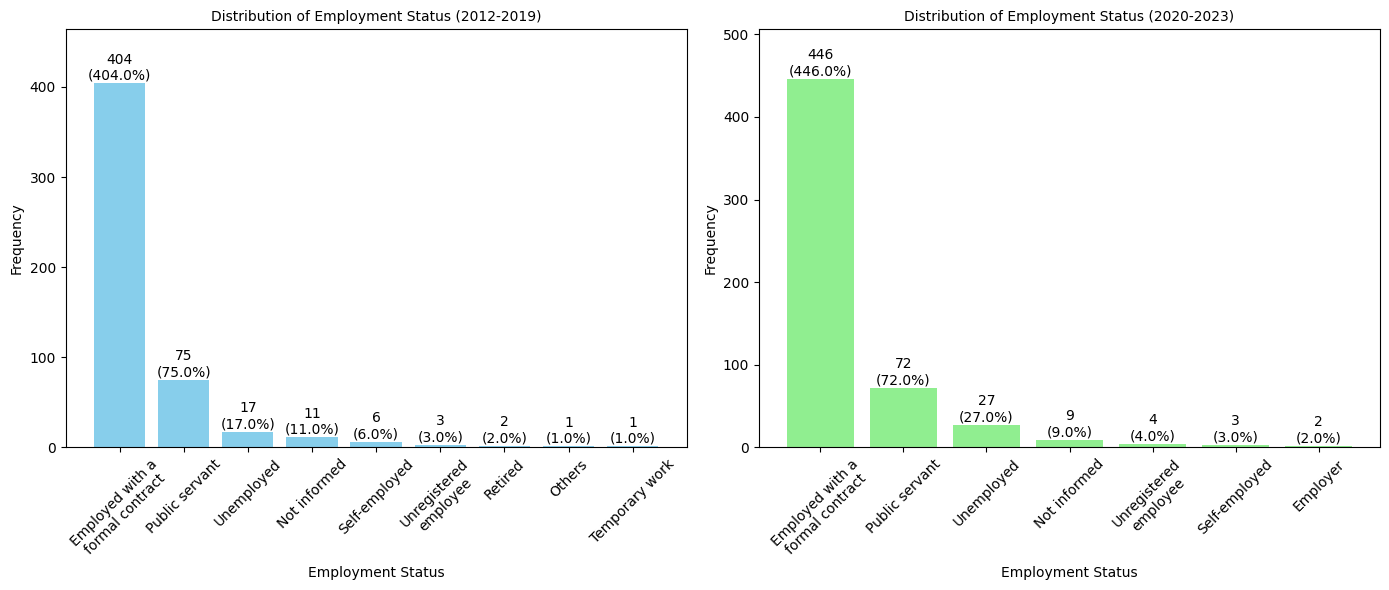

In [44]:
# Agrupar por 'SITUACAO' e contar as ocorrências para df_sp_a1
df_situacao_a1 = df_sp_a1.groupby('SITUACAO').size().sort_values(ascending=False).reset_index(name='counts')
total_a1 = df_situacao_a1['counts'].sum()
df_situacao_a1['percent'] = (df_situacao_a1['counts'] / total_a1) * 100

# Agrupar por 'SITUACAO' e contar as ocorrências para df_sp_a2
df_situacao_a2 = df_sp_a2.groupby('SITUACAO').size().sort_values(ascending=False).reset_index(name='counts')
total_a2 = df_situacao_a2['counts'].sum()
df_situacao_a2['percent'] = (df_situacao_a2['counts'] / total_a2) * 100

# Criando a figura e os eixos para os subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 linha, 2 colunas

# Gráfico para df_sp_a1 (2012-2019)
bars_a1 = axes[0].bar(df_situacao_a1['SITUACAO'], df_situacao_a1['counts'], color='skyblue')
axes[0].set_title('Distribution of Employment Status (2012-2019)', fontsize=10)
axes[0].set_xlabel('Employment Status', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)

# Adicionando os valores absolutos e percentuais acima de cada barra no gráfico a1
for i, bar in enumerate(bars_a1):
    yval = bar.get_height()
    count = df_situacao_a1['counts'].iloc[i]
    axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{count}\n({yval:.1f}%)', ha='center', va='bottom')

# Rotacionando os rótulos do eixo X para melhor legibilidade, se necessário
axes[0].tick_params(axis='x', rotation=45)

# Gráfico para df_sp_a2 (2020-2023)
bars_a2 = axes[1].bar(df_situacao_a2['SITUACAO'], df_situacao_a2['counts'], color='lightgreen')
axes[1].set_title('Distribution of Employment Status (2020-2023)', fontsize=10)
axes[1].set_xlabel('Employment Status', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)

# Adicionando os valores absolutos e percentuais acima de cada barra no gráfico a2
for i, bar in enumerate(bars_a2):
    yval = bar.get_height()
    count = df_situacao_a2['counts'].iloc[i]
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{count}\n({yval:.1f}%)', ha='center', va='bottom', fontsize=10)

# Ajustar rótulos do eixo y com quebra de linha
wrapped_labels_a1_s = [textwrap.fill(label, width=20) for label in df_situacao_a1['SITUACAO']]
wrapped_labels_a2_s = [textwrap.fill(label, width=20) for label in df_situacao_a2['SITUACAO']]

# Atualizar os rótulos do eixo x
axes[0].set_xticklabels(wrapped_labels_a1_s)
axes[1].set_xticklabels(wrapped_labels_a2_s)

# Rotacionando os rótulos do eixo X para melhor legibilidade, se necessário
axes[1].tick_params(axis='x', rotation=45)

# Atualizar os rótulos do eixo y
axes[0].set_ylim(0, max(df_situacao_a1.counts)+60)
axes[1].set_ylim(0, max(df_situacao_a2.counts)+60)


# Ajustar o layout para que os rótulos não se sobreponham
plt.tight_layout()



# Exibir o gráfico
plt.show()


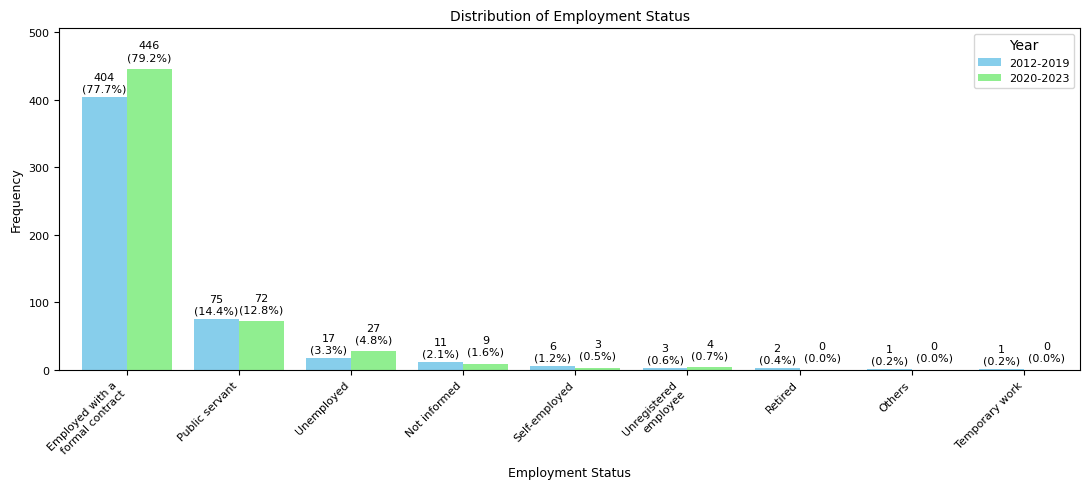

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Exemplo de como você pode agrupar os dados para df_sp_a1 e df_sp_a2
df_situacao_a1 = df_sp_a1.groupby('SITUACAO').size().sort_values(ascending=False).reset_index(name='counts')
total_a1 = df_situacao_a1['counts'].sum()
df_situacao_a1['percent'] = (df_situacao_a1['counts'] / total_a1) * 100

df_situacao_a2 = df_sp_a2.groupby('SITUACAO').size().sort_values(ascending=False).reset_index(name='counts')
total_a2 = df_situacao_a2['counts'].sum()
df_situacao_a2['percent'] = (df_situacao_a2['counts'] / total_a2) * 100

# Lista com todas as categorias desejadas
all_categories = [
    'Employed with a formal contract',
    'Public servant',
    'Unemployed',
    'Not informed',
    'Self-employed',
    'Unregistered employee',
    'Retired',
    'Others',
    'Temporary work'
]

# Reindexando df_situacao_a1 e df_situacao_a2 para incluir categorias com contagem 0
df_situacao_a1 = df_situacao_a1.set_index('SITUACAO').reindex(all_categories, fill_value=0).reset_index()
df_situacao_a1.columns = ['SITUACAO', 'counts', 'percent']

df_situacao_a2 = df_situacao_a2.set_index('SITUACAO').reindex(all_categories, fill_value=0).reset_index()
df_situacao_a2.columns = ['SITUACAO', 'counts', 'percent']

# Configurar a largura das barras
bar_width = 0.4

# Criando uma lista de índices para as barras
indices = np.arange(len(all_categories))

# Criando a figura e os eixos
fig, ax = plt.subplots(figsize=(11, 5))  # Aumentando o tamanho da figura

# Adicionando as barras do primeiro DataFrame (2012-2019)
bars_a1 = ax.bar(indices, df_situacao_a1['counts'], width=bar_width, color='skyblue', label='2012-2019')

# Adicionando as barras do segundo DataFrame (2020-2023)
bars_a2 = ax.bar(indices + bar_width, df_situacao_a2['counts'], width=bar_width, color='lightgreen', label='2020-2023')

# Configurando o gráfico
ax.set_title('Distribution of Employment Status', fontsize=10)
ax.set_xlabel('Employment Status', fontsize=9)
ax.set_ylabel('Frequency', fontsize=9)
ax.set_xticks(indices + bar_width / 2)  # Ajustar os ticks do eixo x para o meio entre as barras
wrapped_labels = [textwrap.fill(label, width=20) for label in all_categories]  # Ajuste a largura se necessário
ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=8)  # Rótulos com quebra de linha
ax.tick_params(axis='y', labelsize=8)
# Adicionando os valores absolutos e percentuais acima de cada barra
for bar in bars_a1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval}\n({(yval/total_a1)*100:.1f}%)',  # Reduzindo a altura
            ha='center', va='bottom', fontsize=8)

for bar in bars_a2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 10, f'{yval}\n({(yval/total_a2)*100:.1f}%)',  # Reduzindo a altura
            ha='center', va='bottom', fontsize=8)

# Adicionar legenda
ax.legend(title='Year', loc='upper right', fontsize=8)

# Ajustando o limite do eixo y
ax.set_ylim(0, max(max(df_situacao_a1.counts), max(df_situacao_a2.counts)) + 60)
ax.set_xlim(-0.4,8.7)

# Ajustar o layout
plt.tight_layout()
plt.show()


## Gênero do trabalhador com ansiedade

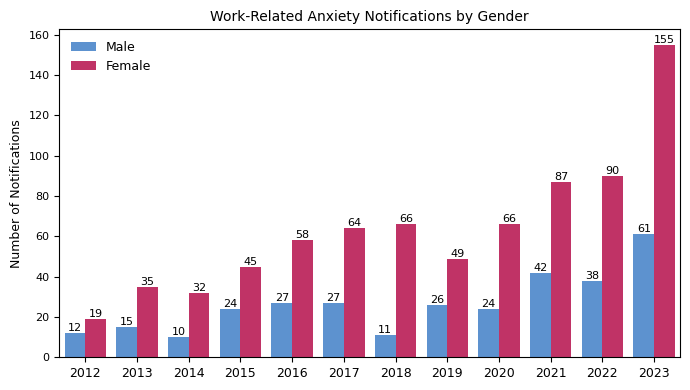

In [46]:
import matplotlib.dates as mdates

# Supondo que df_sp_a já esteja definido corretamente

# 1. Filtrar os dados para masculino e feminino
df_m = df_sp_a[df_sp_a['CS_SEXO'] == 'M']
df_f = df_sp_a[df_sp_a['CS_SEXO'] == 'F']

# 2. Agrupar os dados por ano e contar as ocorrências
df_m_grouped = df_m.resample('A').size()  # Agrupa por ano e conta
df_f_grouped = df_f.resample('A').size()  # Agrupa por ano e conta

# 3. Criar um DataFrame para facilitar a plotagem
df_combined = pd.DataFrame({
    'Ano': df_m_grouped.index.year,
    'Male': df_m_grouped.values,
    'Female': df_f_grouped.values
})

# 4. Derreter o DataFrame para o formato longo
df_long = df_combined.melt(id_vars='Ano', var_name='Gênero', value_name='Contagem')

# 6. Criar o gráfico de barras
plt.figure(figsize=(7, 4))  # Define o tamanho da figura
ax = plt.gca()  # Obtém o eixo atual

# Definindo as cores pastel desejadas
colors = ['#4A90E2', '#D81B60']  # Azul pastel e rosa pastel

sns.barplot(data=df_long, x='Ano', y='Contagem', hue='Gênero', palette=colors, ax=ax)

# Título e rótulos dos eixos
plt.title('Work-Related Anxiety Notifications by Gender',fontsize=10)
plt.xlabel('', fontsize=9)
plt.ylabel('Number of Notifications', fontsize=9)

# Formatação do eixo x
plt.xticks(rotation=0, fontsize=9)  # Ajusta os ticks do eixo X
plt.yticks(fontsize=8)  # Ajusta os ticks do eixo X
#ax.grid(axis='y', zorder=0)

# Rótulo
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:  # Verifica se a altura é maior que 0
        color = p.get_facecolor()  # Obtém a cor da barra
        ax.annotate(f'{height}',
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=8, color="black")

# Configura a legenda sem borda
legend = ax.legend(fontsize=9)
legend.set_frame_on(False)

#plt.legend(title='', fontsize=9)

# Ajuste o layout para melhor visualização
plt.tight_layout()

# Mostra o gráfico
plt.show()


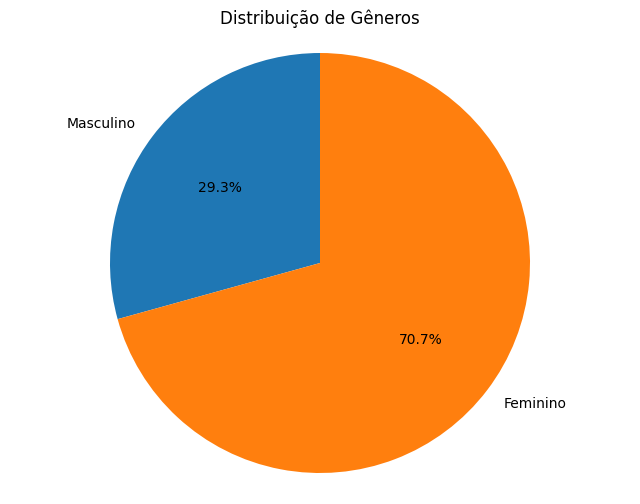

In [47]:

# Supondo que df_sp_a já está definido e contém a coluna 'CS_SEXO'
# Filtrando os dados
df_m = df_sp_a2[df_sp_a2['CS_SEXO'] == 'M']
df_f = df_sp_a2[df_sp_a2['CS_SEXO'] == 'F']

# Contando o número de ocorrências de cada sexo
count_m = len(df_m)
count_f = len(df_f)

# Preparando os dados para o gráfico
labels = ['Masculino', 'Feminino']
sizes = [count_m, count_f]
colors = ['#1f77b4', '#ff7f0e']  # cores para cada fatia

# Criando o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Para garantir que o gráfico seja um círculo
plt.title('Distribuição de Gêneros')
plt.show()


## Associação de alcool, drogas, Psicofármacos, Fuma

In [48]:
qtd_alcool1 = df_sp_a1[df_sp_a1['ALCOOL']=='Yes'].shape[0]
perc_alcool1 = qtd_alcool1 / df_sp_a1['ALCOOL'].count()

qtd_drogas1 = df_sp_a1[df_sp_a1['DROGAS']=='Yes'].shape[0]
perc_drogas1 = qtd_drogas1 / df_sp_a1['DROGAS'].count()

qtd_farm1 = df_sp_a1[df_sp_a1['PSICO_FARM']=='Yes'].shape[0]
perc_farm1 = qtd_farm1 / df_sp_a1['PSICO_FARM'].count()

qtd_fuma1 = df_sp_a1[df_sp_a1['FUMA']=='Yes'].shape[0]
perc_fuma1 = qtd_fuma1 / df_sp_a1['FUMA'].count()

qtd_alcool2 = df_sp_a2[df_sp_a2['ALCOOL']=='Yes'].shape[0]
perc_alcool2 = qtd_alcool2 / df_sp_a2['ALCOOL'].count()

qtd_drogas2 = df_sp_a2[df_sp_a2['DROGAS']=='Yes'].shape[0]
perc_drogas2 = qtd_drogas2 / df_sp_a2['DROGAS'].count()

qtd_farm2 = df_sp_a2[df_sp_a2['PSICO_FARM']=='Yes'].shape[0]
perc_farm2 = qtd_farm2 / df_sp_a2['PSICO_FARM'].count()

qtd_fuma2 = df_sp_a2[df_sp_a2['FUMA']=='Yes'].shape[0]
perc_fuma2 = qtd_fuma2 / df_sp_a2['FUMA'].count()



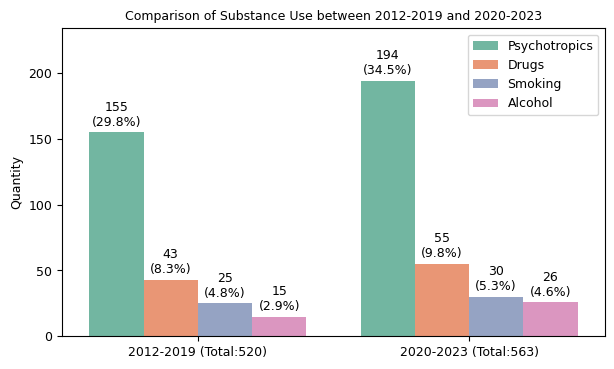

In [49]:
# Create the DataFrame with the data
total_2012_2019 = len(df_sp_a1)
total_2020_2023 = len(df_sp_a2)

dados_c = pd.DataFrame({
    'Period': ['2012-2019 (Total:{})'.format(total_2012_2019), '2012-2019 (Total:{})'.format(total_2012_2019), '2012-2019 (Total:{})'.format(total_2012_2019), '2012-2019 (Total:{})'.format(total_2012_2019),
               '2020-2023 (Total:{})'.format(total_2020_2023), '2020-2023 (Total:{})'.format(total_2020_2023), '2020-2023 (Total:{})'.format(total_2020_2023), '2020-2023 (Total:{})'.format(total_2020_2023)],
    'Qty': [qtd_alcool1, qtd_drogas1, qtd_farm1, qtd_fuma1,
            qtd_alcool2, qtd_drogas2, qtd_farm2, qtd_fuma2],
    'Category': ['Alcohol', 'Drugs', 'Psychotropics', 'Smoking',
                 'Alcohol', 'Drugs', 'Psychotropics', 'Smoking']
})

# Sort the data by period and quantity (from highest to lowest)
dados_c = dados_c.sort_values(by=['Period', 'Qty'], ascending=[True, False])

# Create the bar plot with Seaborn
plt.figure(figsize=(7, 4))  # Increase width to accommodate more bars
barplot = sns.barplot(x='Period', y='Qty', hue='Category', data=dados_c,  palette='Set2', dodge=True)

# Add titles and labels
plt.ylabel('Quantity', fontsize=9)  # Change "Qty de Sim (%)" to "Quantity of Yes"
plt.xlabel('', fontsize=9)  # Change "Qty de Sim (%)" to "Quantity of Yes"
plt.title('Comparison of Substance Use between 2012-2019 and 2020-2023', fontsize=9)

# Display the absolute quantities and percentages on top of the bars
for i, bar in enumerate(barplot.patches):

    if i < len(dados_c):
      # Get the height of each bar and the x position
      height = bar.get_height()
      x = bar.get_x() + bar.get_width() / 2  # Center it in the middle of the bar

      # Calculate percentage for each bar except totals
      if bar.get_x() < (barplot.get_xticks()[1] + barplot.get_xticks()[0]) / 2:
         percentage = (height / total_2012_2019 * 100)
      else:
         percentage = (height / total_2020_2023 * 100)

      percentage_label = f"{percentage:.1f}%"

      # Show the label only if the value is not zero
      if height > 0:
          plt.text(x, height + 5, f"{int(height)}\n({percentage_label})", ha='center', fontsize=9)  # Display absolute and percentage directly

# Adjust the y-axis to display the correct values
plt.ylim(0, max(dados_c['Qty']) + 40)  # Adjust the y-axis limit to accommodate the labels

# Formatação do eixo x
plt.xticks(rotation=0, fontsize=9)  # Ajusta os ticks do eixo X
plt.yticks(fontsize=9)  # Ajusta os ticks do eixo X
#ax.grid(axis='y', zorder=0)

# Show the plot
plt.legend(title='', fontsize=9)  # Add a title to the legend
plt.show()

## Idade

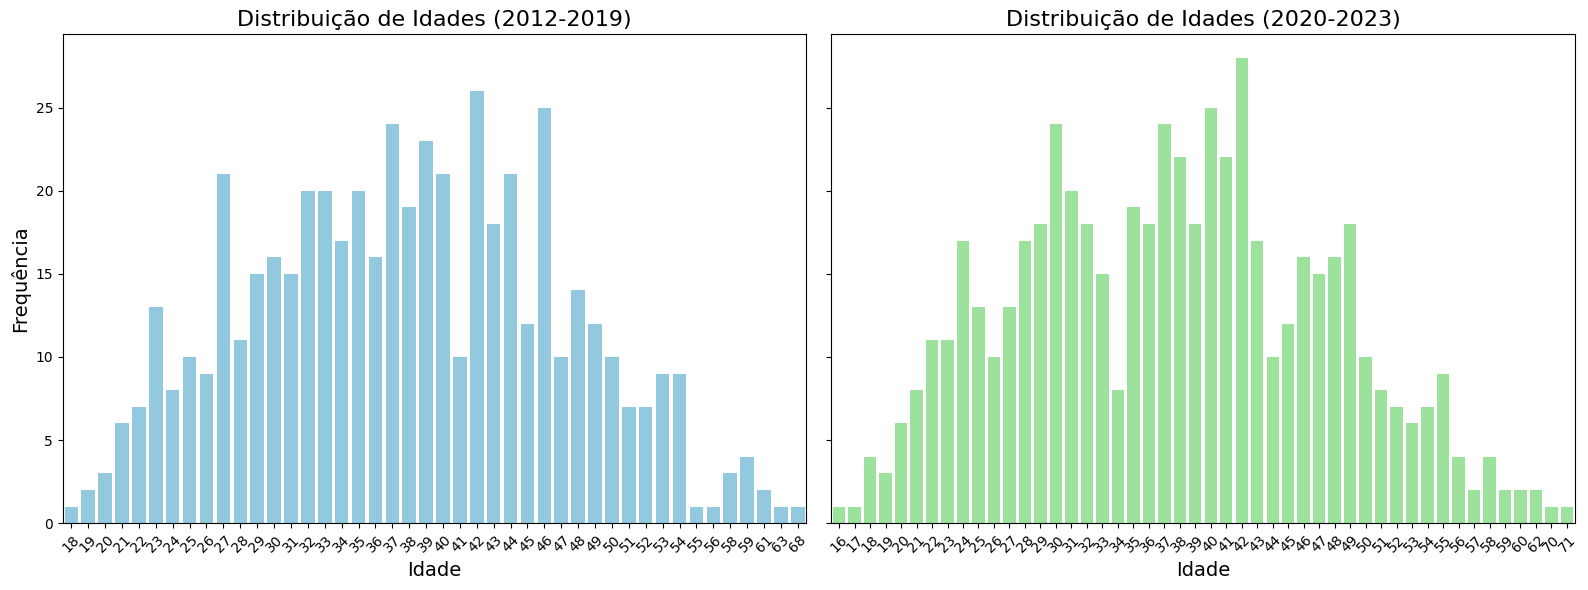

In [50]:

# Contando as frequências de cada idade para df_sp_a1 (2012-2019)
idade_counts_a1 = df_sp_a1['IDADE'].value_counts().sort_index()

# Contando as frequências de cada idade para df_sp_a2 (2020-2023)
idade_counts_a2 = df_sp_a2['IDADE'].value_counts().sort_index()

# Criando subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 linha, 2 colunas de gráficos

# Plotando o gráfico de barras para df_sp_a1 (2012-2019)
sns.barplot(x=idade_counts_a1.index, y=idade_counts_a1.values, ax=axes[0], color="skyblue")
axes[0].set_title('Distribuição de Idades (2012-2019)', fontsize=16)
axes[0].set_xlabel('Idade', fontsize=14)
axes[0].set_ylabel('Frequência', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Plotando o gráfico de barras para df_sp_a2 (2020-2023)
sns.barplot(x=idade_counts_a2.index, y=idade_counts_a2.values, ax=axes[1], color="lightgreen")
axes[1].set_title('Distribuição de Idades (2020-2023)', fontsize=16)
axes[1].set_xlabel('Idade', fontsize=14)
axes[1].set_ylabel('Frequência', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

# Ajustando o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()


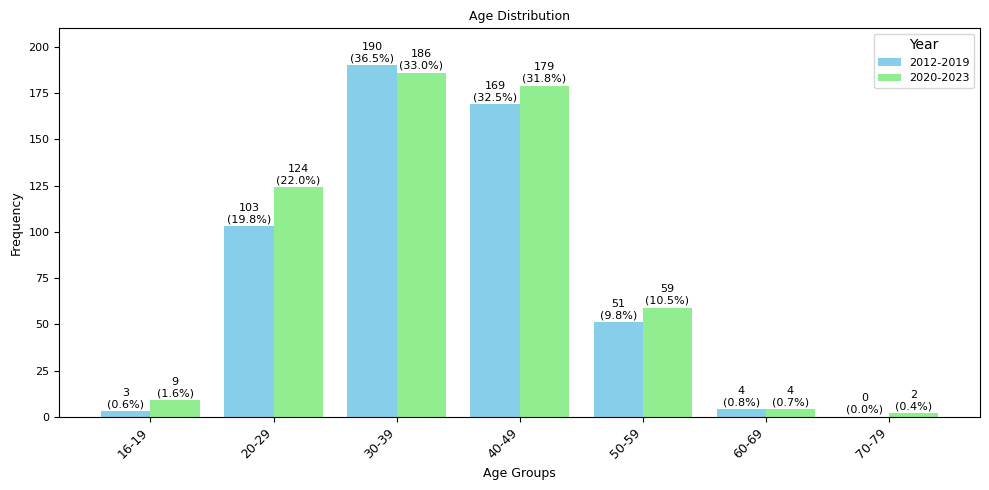

In [51]:
# Definindo os bins de idade e as labels
bins = [16, 20, 30, 40, 50, 60, 70, 80]
labels = ['16-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

# Supondo que as idades já estão agrupadas
# Contagem de idades para os dois DataFrames
idade_counts_a1 = df_sp_a1['AGE_GROUP'].value_counts().reindex(labels, fill_value=0)
idade_counts_a2 = df_sp_a2['AGE_GROUP'].value_counts().reindex(labels, fill_value=0)

# Calculando a porcentagem
idade_counts_a1_percent = (idade_counts_a1 / idade_counts_a1.sum()) * 100
idade_counts_a2_percent = (idade_counts_a2 / idade_counts_a2.sum()) * 100

# Configurar a largura das barras
bar_width = 0.4

# Criando uma lista de índices para as barras
indices = np.arange(len(labels))

# Criando a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 5))  # Aumentando o tamanho da figura

# Adicionando as barras do primeiro DataFrame (2012-2019)
bars_a1 = ax.bar(indices, idade_counts_a1.values, width=bar_width, color='skyblue', label='2012-2019')

# Adicionando as barras do segundo DataFrame (2020-2023)
bars_a2 = ax.bar(indices + bar_width, idade_counts_a2.values, width=bar_width, color='lightgreen', label='2020-2023')

# Configurando o gráfico
ax.set_title('Age Distribution', fontsize=9)
ax.set_xlabel('Age Groups', fontsize=9)
ax.set_ylabel('Frequency', fontsize=9)

# Adicionando rótulos nas barras
for i, bar in enumerate(bars_a1):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}\n({idade_counts_a1_percent[i]:.1f}%)',
            ha='center', va='bottom', fontsize=8)

for i, bar in enumerate(bars_a2):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}\n({idade_counts_a2_percent[i]:.1f}%)',
            ha='center', va='bottom', fontsize=8)

# Ajustando os rótulos do eixo x
ax.set_xticks(indices + bar_width / 2)  # Ajustar os ticks do eixo x para o meio entre as barras
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.tick_params(axis='y', labelsize=8)

# Adicionar legenda
ax.legend(title='Year', loc='upper right', fontsize=8)

# Ajustando o limite do eixo y
ax.set_ylim(0, max(max(idade_counts_a1.values), max(idade_counts_a2.values)) + 20)



# Ajustar o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()


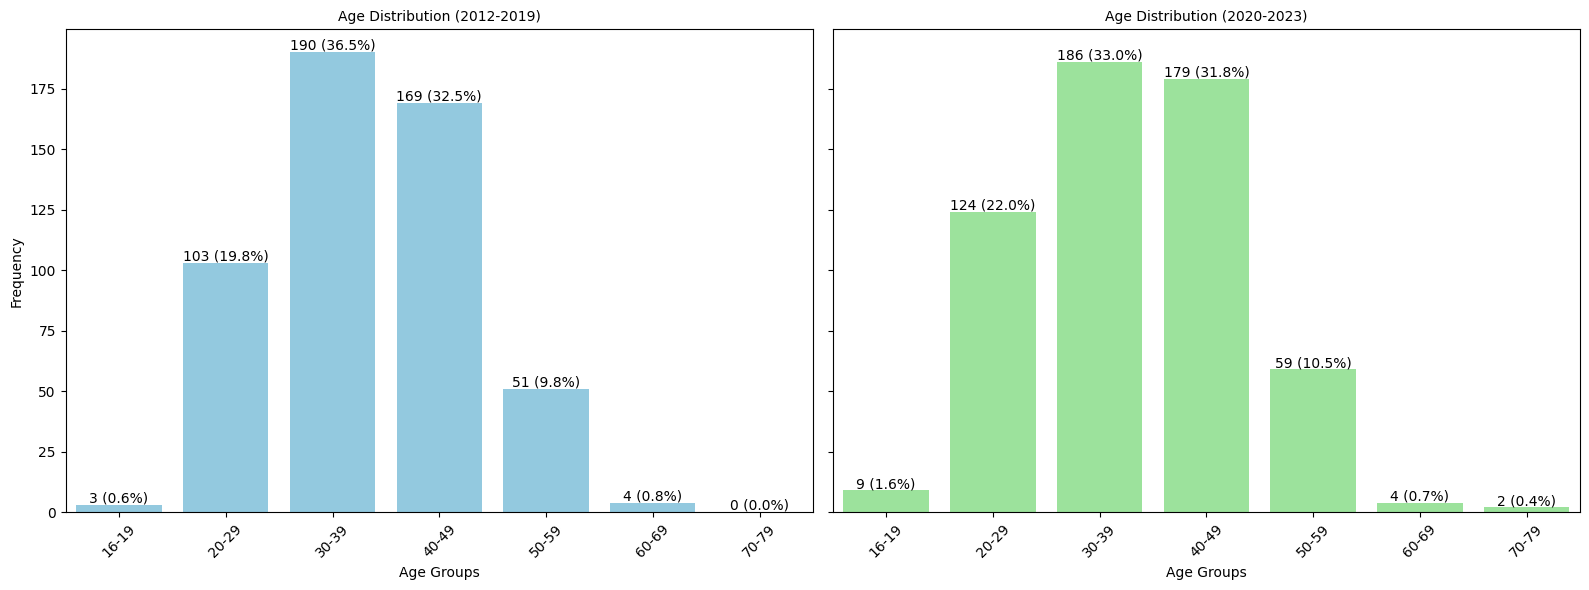

In [52]:
# Definindo os bins de idade
bins = [16, 20, 30, 40, 50, 60, 70, 80]
labels = ['16-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

idade_counts_a1 = df_sp_a1['AGE_GROUP'].value_counts().sort_index()

idade_counts_a2 = df_sp_a2['AGE_GROUP'].value_counts().sort_index()

# Calculando a porcentagem
idade_counts_a1_percent = (idade_counts_a1 / idade_counts_a1.sum()) * 100
idade_counts_a2_percent = (idade_counts_a2 / idade_counts_a2.sum()) * 100

# Criando subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 linha, 2 colunas de gráficos

# Plotando o gráfico de barras para df_sp_a1 (2012-2019)
sns.barplot(x=idade_counts_a1.index, y=idade_counts_a1.values, ax=axes[0], color="skyblue")
axes[0].set_title('Age Distribution (2012-2019)', fontsize=10)
axes[0].set_xlabel('Age Groups', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Adicionando porcentagens como rótulos nas barras do gráfico a1
for i, v in enumerate(idade_counts_a1.values):
    axes[0].text(i, v + 1, f"{v} ({idade_counts_a1_percent[i]:.1f}%)", ha='center')

# Plotando o gráfico de barras para df_sp_a2 (2020-2023)
sns.barplot(x=idade_counts_a2.index, y=idade_counts_a2.values, ax=axes[1], color="lightgreen")
axes[1].set_title('Age Distribution (2020-2023)', fontsize=10)
axes[1].set_xlabel('Age Groups', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

# Adicionando porcentagens como rótulos nas barras do gráfico a2
for i, v in enumerate(idade_counts_a2.values):
    axes[1].text(i, v + 1, f"{v} ({idade_counts_a2_percent[i]:.1f}%)", ha='center')


# Ajustando o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()


In [53]:
idade_counts_a2.index

CategoricalIndex(['16-19', '20-29', '30-39', '40-49', '50-59', '60-69',
                  '70-79'],
                 categories=['16-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79'], ordered=True, dtype='category', name='AGE_GROUP')

## Evolução

In [54]:
"""
1- Cura
2- Cura não confirmada
3- Incapacidade temporária
4- Incapacidade permanente parcial
5- Incapacidade permanente total
6- Óbito por doença relacionada ao trabalho
7- Óbito por outra causa
8- Outro
9- Ignorado
"""
print(df_sp_a1.EVOLUCAO.value_counts())
print(df_sp_a2.EVOLUCAO.value_counts())

EVOLUCAO
Temporary Disability            288
Not informed                    120
Unconfirmed Cure                 41
Other                            36
Cure                             16
Partial Permanent Disability     16
Total Permanent Disability        3
Name: count, dtype: int64
EVOLUCAO
Temporary Disability            292
Not informed                    100
Unconfirmed Cure                 88
Other                            61
Cure                             14
Partial Permanent Disability      8
Name: count, dtype: int64


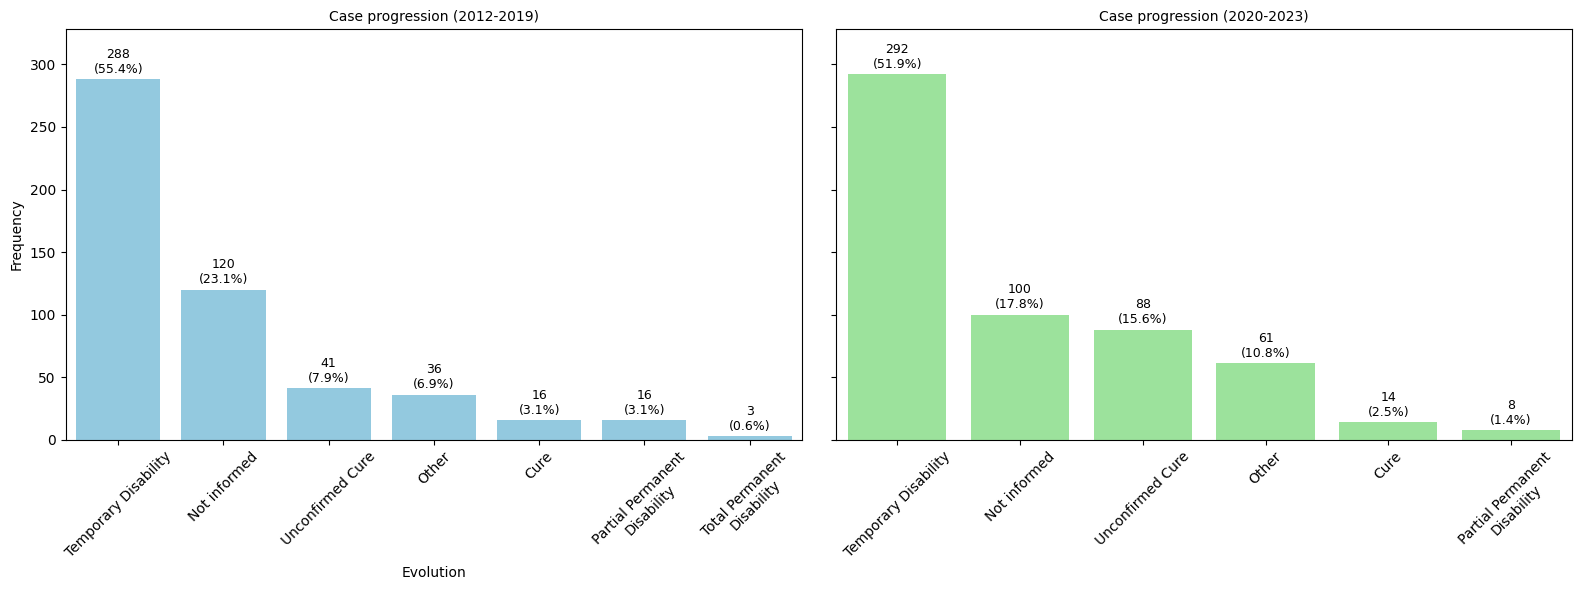

In [55]:
# Contando as frequências de cada categoria para df_sp_a1 (2012-2019)
evolucao_counts_a1 = df_sp_a1['EVOLUCAO'].value_counts().sort_values(ascending=False)
total_a1 = len(df_sp_a1)

# Contando as frequências de cada categoria para df_sp_a2 (2020-2023)
evolucao_counts_a2 = df_sp_a2['EVOLUCAO'].value_counts().sort_values(ascending=False)
total_a2 = len(df_sp_a2)

# Criando subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 linha, 2 colunas de gráficos

# Plotando o gráfico de barras para df_sp_a1 (2012-2019)
sns.barplot(x=evolucao_counts_a1.index, y=evolucao_counts_a1.values, ax=axes[0], color="skyblue")
axes[0].set_title('Case progression (2012-2019)', fontsize=10)
axes[0].set_xlabel('Evolution', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Exibir as quantidades e porcentagens no gráfico df_sp_a1
for i, bar in enumerate(axes[0].patches):
    height = bar.get_height()
    percentage = (height / total_a1) * 100
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}\n({percentage:.1f}%)",
                  ha='center', fontsize=9)

# Plotando o gráfico de barras para df_sp_a2 (2020-2023)
sns.barplot(x=evolucao_counts_a2.index, y=evolucao_counts_a2.values, ax=axes[1], color="lightgreen")
axes[1].set_title('Case progression (2020-2023)', fontsize=10)
axes[1].set_xlabel('', fontsize=9)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)



# Exibir as quantidades e porcentagens no gráfico df_sp_a2
for i, bar in enumerate(axes[1].patches):
    height = bar.get_height()
    percentage = (height / total_a2) * 100
    axes[1].text(bar.get_x() + bar.get_width() / 2, height+5, f"{int(height)}\n({percentage:.1f}%)",
                  ha='center', fontsize=9)


# Ajustar rótulos do eixo y com quebra de linha
wrapped_labels_a1_e = [textwrap.fill(label, width=20) for label in evolucao_counts_a1.index]
wrapped_labels_a2_e = [textwrap.fill(label, width=20) for label in evolucao_counts_a2.index]


# Atualizar os rótulos do eixo x
axes[0].set_xticklabels(wrapped_labels_a1_e)
axes[1].set_xticklabels(wrapped_labels_a2_e)


# Atualizar os rótulos do eixo y
#axes[0].set_yticks(evolucao_counts_a1.values)
#axes[1].set_yticks([])

axes[1].set_ylim(0, max(evolucao_counts_a2.values) + 40)
axes[0].set_ylim(0, max(evolucao_counts_a1.values) + 40)
# Ajustando o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

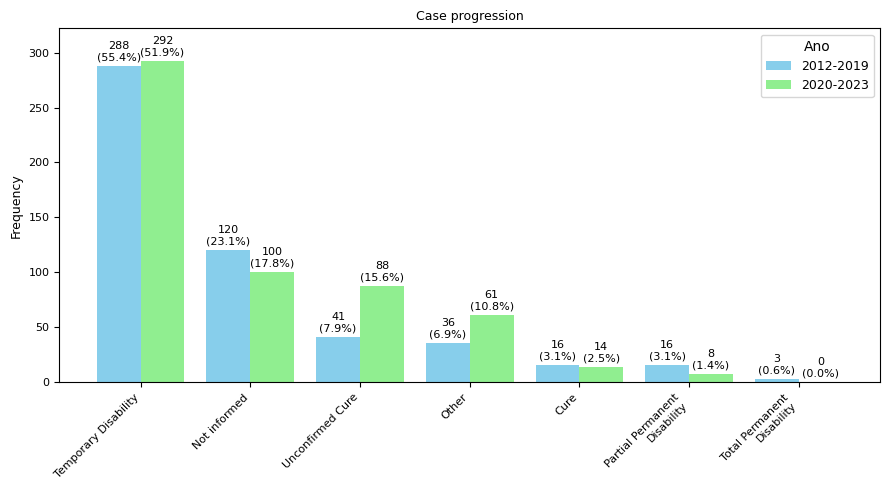

In [56]:
# Definindo as categorias
categories = [
    'Temporary Disability',
    'Not informed',
    'Unconfirmed Cure',
    'Other',
    'Cure',
    'Partial Permanent Disability',
    'Total Permanent Disability'
]

# Contando as frequências de cada categoria para df_sp_a1 (2012-2019)
evolucao_counts_a1 = df_sp_a1['EVOLUCAO'].value_counts().reindex(categories, fill_value=0)
total_a1 = len(df_sp_a1)

# Contando as frequências de cada categoria para df_sp_a2 (2020-2023)
evolucao_counts_a2 = df_sp_a2['EVOLUCAO'].value_counts().reindex(categories, fill_value=0)
total_a2 = len(df_sp_a2)

# Configurar a largura das barras
bar_width = 0.4

# Criando a figura e os eixos
fig, ax = plt.subplots(figsize=(9, 5))  # Aumentando o tamanho da figura

# Plotando as barras de evolução para df_sp_a1 (2012-2019)
indices_a1 = np.arange(len(evolucao_counts_a1))
bars_a1 = ax.bar(indices_a1, evolucao_counts_a1.values, width=bar_width, color='skyblue', label='2012-2019')

# Plotando as barras de evolução para df_sp_a2 (2020-2023)
bars_a2 = ax.bar(indices_a1 + bar_width, evolucao_counts_a2.values, width=bar_width, color='lightgreen', label='2020-2023')

# Ajustando os rótulos do eixo x com quebra de linha
wrapped_labels = [textwrap.fill(label, width=20) for label in evolucao_counts_a1.index]
ax.set_xticks(indices_a1 + bar_width / 2)
ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=8)

# Adicionando rótulos com quantidades e porcentagens nas barras do gráfico a1
for i, bar in enumerate(bars_a1):
    height = bar.get_height()
    percentage = (height / total_a1) * 100
    ax.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}\n({percentage:.1f}%)", ha='center', fontsize=8)

# Adicionando rótulos com quantidades e porcentagens nas barras do gráfico a2
for i, bar in enumerate(bars_a2):
    height = bar.get_height()
    percentage = (height / total_a2) * 100
    ax.text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}\n({percentage:.1f}%)", ha='center', fontsize=8)

# Configurando o título e rótulos
ax.set_title('Case progression', fontsize=9)
ax.set_xlabel('', fontsize=9)
ax.set_ylabel('Frequency', fontsize=9)
ax.legend(title='Ano', fontsize=9)
ax.tick_params(axis='y', labelsize=8)

# Ajustando o limite do eixo y
ax.set_ylim(0, max(evolucao_counts_a1.max(), evolucao_counts_a2.max()) + 30)

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()


## CAPES
encaminhando a um centro de atenção psicossocial (CAPES) no SUS ou
outro serviço especializado em tratamento de transtornos mentais

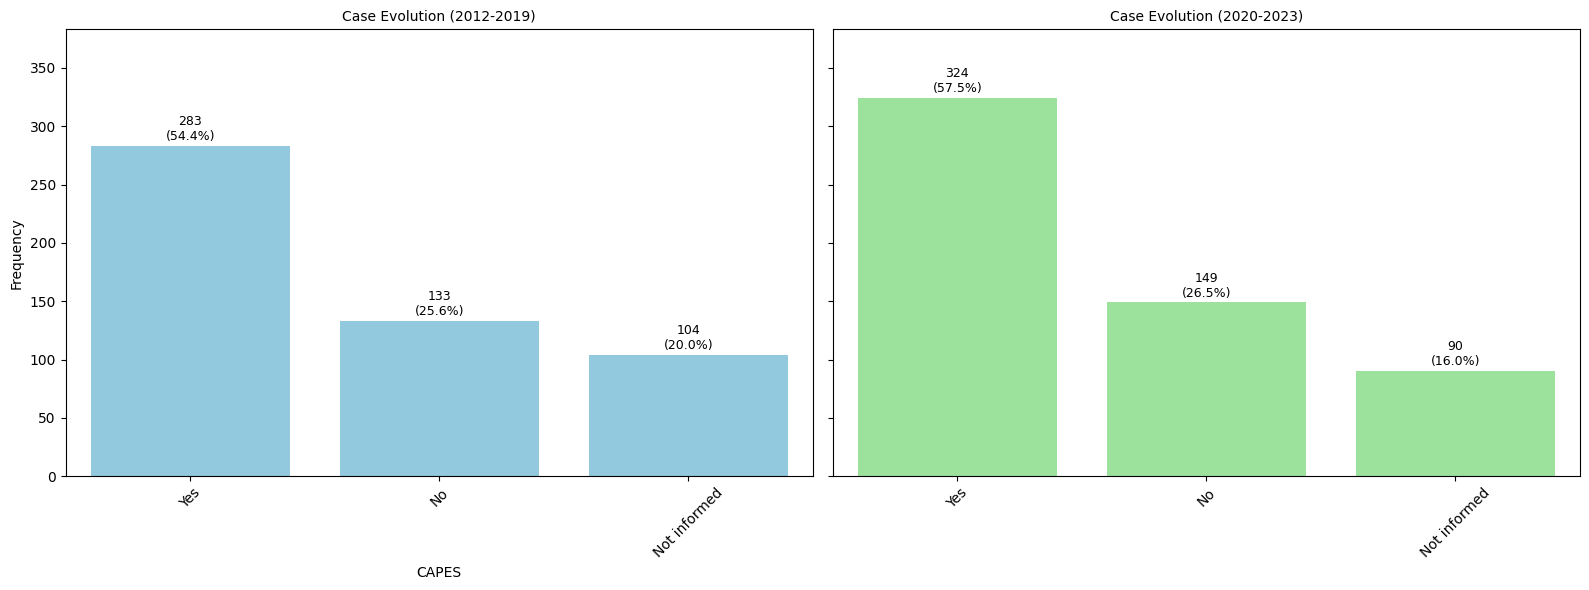

In [57]:
# Contando as frequências de cada categoria para df_sp_a1 (2012-2019)
capes_counts_a1 = df_sp_a1['CAPES'].value_counts().sort_values(ascending=False)
total_a1 = len(df_sp_a1)

# Contando as frequências de cada categoria para df_sp_a2 (2020-2023)
capes_counts_a2 = df_sp_a2['CAPES'].value_counts().sort_values(ascending=False)
total_a2 = len(df_sp_a2)

# Criando subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 linha, 2 colunas de gráficos

# Plotando o gráfico de barras para df_sp_a1 (2012-2019)
sns.barplot(x=capes_counts_a1.index, y=capes_counts_a1.values, ax=axes[0], color="skyblue")
axes[0].set_title('Case Evolution (2012-2019)', fontsize=10)
axes[0].set_xlabel('CAPES', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Exibir as quantidades e porcentagens no gráfico df_sp_a1
for i, bar in enumerate(axes[0].patches):
    height = bar.get_height()
    percentage = (height / total_a1) * 100
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}\n({percentage:.1f}%)",
                  ha='center', fontsize=9)

# Plotando o gráfico de barras para df_sp_a2 (2020-2023)
sns.barplot(x=capes_counts_a2.index, y=capes_counts_a2.values, ax=axes[1], color="lightgreen")
axes[1].set_title('Case Evolution (2020-2023)', fontsize=10)
axes[1].set_xlabel('', fontsize=9)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

# Exibir as quantidades e porcentagens no gráfico df_sp_a2
for i, bar in enumerate(axes[1].patches):
    height = bar.get_height()
    percentage = (height / total_a2) * 100
    axes[1].text(bar.get_x() + bar.get_width() / 2, height + 5, f"{int(height)}\n({percentage:.1f}%)",
                  ha='center', fontsize=9)


# Atualizar os rótulos do eixo y
axes[1].set_ylim(0, max(capes_counts_a2.values) + 100)
axes[0].set_ylim(0, max(capes_counts_a1.values) + 100)

# Ajustando o layout
plt.tight_layout()

# Exibir o gráfico
plt.show()


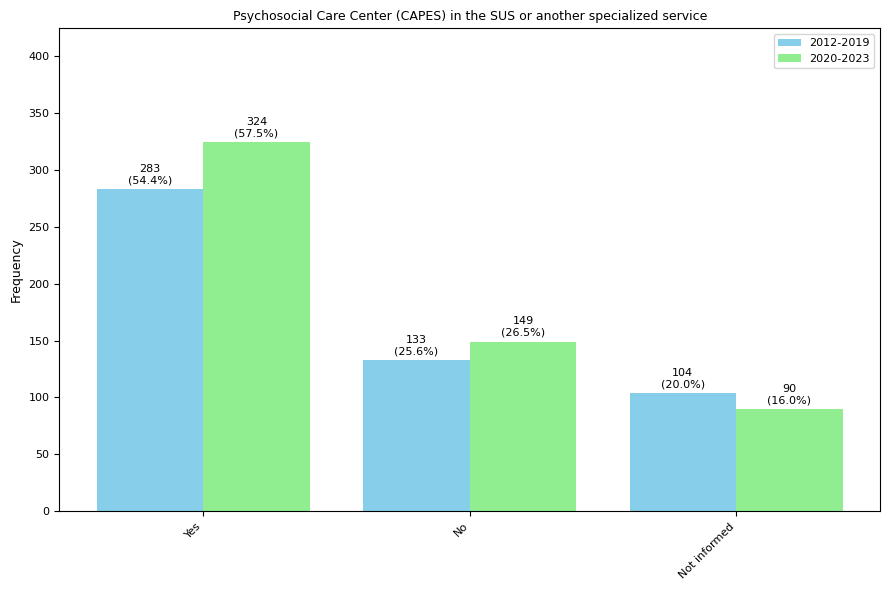

In [58]:
# Contando as frequências de cada categoria para df_sp_a1 (2012-2019)
capes_counts_a1 = df_sp_a1['CAPES'].value_counts().sort_values(ascending=False)
total_a1 = len(df_sp_a1)

# Contando as frequências de cada categoria para df_sp_a2 (2020-2023)
capes_counts_a2 = df_sp_a2['CAPES'].value_counts().sort_values(ascending=False)
total_a2 = len(df_sp_a2)

# Definir as categorias comuns e alinhar ambos os datasets
categories = ['Yes','No','Not informed']
capes_counts_a1 = capes_counts_a1.reindex(categories, fill_value=0)
capes_counts_a2 = capes_counts_a2.reindex(categories, fill_value=0)

# Configurar a largura das barras
bar_width = 0.4
indices = np.arange(len(categories))  # Posições para as categorias no eixo x

# Criar a figura
fig, ax = plt.subplots(figsize=(9, 6))

# Plotar as barras para 2012-2019
bars_a1 = ax.bar(indices - bar_width/2, capes_counts_a1.values, width=bar_width, color="skyblue", label="2012-2019")

# Plotar as barras para 2020-2023
bars_a2 = ax.bar(indices + bar_width/2, capes_counts_a2.values, width=bar_width, color="lightgreen", label="2020-2023")

# Adicionar rótulos de porcentagem nas barras de 2012-2019
for i, bar in enumerate(bars_a1):
    height = bar.get_height()
    percentage = (height / total_a1) * 100
    ax.text(bar.get_x() + bar.get_width()/2, height + 5, f"{int(height)}\n({percentage:.1f}%)", ha='center', fontsize=8)

# Adicionar rótulos de porcentagem nas barras de 2020-2023
for i, bar in enumerate(bars_a2):
    height = bar.get_height()
    percentage = (height / total_a2) * 100
    ax.text(bar.get_x() + bar.get_width()/2, height + 5, f"{int(height)}\n({percentage:.1f}%)", ha='center', fontsize=8)

# Ajustar o eixo x com as categorias e seus rótulos
ax.set_xticks(indices)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=8)

# Configurações do gráfico
ax.set_title('Psychosocial Care Center (CAPES) in the SUS or another specialized service', fontsize=9)
ax.set_xlabel('', fontsize=9)
ax.set_ylabel('Frequency', fontsize=9)
ax.legend(title='', fontsize=8)
ax.tick_params(axis='y', labelsize=8)



# Ajustar os limites do eixo y
ax.set_ylim(0, max(capes_counts_a1.max(), capes_counts_a2.max()) + 100)

# Ajustar o layout para melhor exibição
plt.tight_layout()

# Exibir o gráfico
plt.show()


# Modelagem

##Clusterização com Kmodes

In [59]:
!pip install kmodes

In [60]:
!pip show kmodes

Name: kmodes
Version: 0.12.2
Summary: Python implementations of the k-modes and k-prototypes clustering algorithms for clustering categorical data.
Home-page: https://github.com/nicodv/kmodes
Author: Nelis J de Vos
Author-email: njdevos@gmail.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scikit-learn, scipy
Required-by: 


In [61]:
from kmodes.kmodes import KModes

In [62]:
# Evaluate cost of k numbers of clusters for k_Modes
def evaluate_k_cost(df2):
  custo = []
  for num_clusters in list(range(1,16)):
    kmode = KModes(n_clusters=num_clusters, init='Cao', verbose=0, n_init=50, random_state = 5)
    kmode.fit_predict(df2)
    custo.append(kmode.cost_)
    print(custo)
    #Huang (1998) - https://link.springer.com/article/10.1023/A:1009769707641
    #https://www.geeksforgeeks.org/k-mode-clustering-in-python/

  print('t',custo)

  ks = [1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15]
  #sns.lineplot(y=custo,  x=ks, marker='o',color='red')
  #plt.title('The Elbow Method')
  #plt.xlabel('Number of clusters')
  #plt.ylabel('Costs (Dissimilarity)')]

  # Calcular reduções e porcentagens de queda
  reducoes = [custo[i] - custo[i+1] for i in range(len(custo)-1)]
  percent_queda = [(reducao / custo[i]) * 100 for i, reducao in enumerate(reducoes)]

  # Adicionar um valor de 0% para o primeiro k
  percent_queda = [0] + percent_queda

  # Criar o gráfico
  plt.figure(figsize=(10, 6))
  sns.lineplot(y=custo, x=ks, marker='o', color='red')

  # Adicionar rótulos de porcentagem de queda
  for i in range(len(percent_queda)):
      if i > 0:  # Evitar o primeiro k, que é 0%
          plt.text(ks[i]+0.3, custo[i], f"-{percent_queda[i]:.1f}%", color='black', ha='center', va='bottom')

  # Definir títulos e rótulos
  plt.title('The Elbow Method', fontsize=16)
  plt.xlabel('Number of clusters', fontsize=14)
  plt.ylabel('Costs (Dissimilarity)', fontsize=14)

  plt.xticks(ks)

  # Mostrar o gráfico
  plt.grid()
  plt.tight_layout()
  plt.show()

In [63]:
#df_sp_a1_cluster = df_sp_a1[['AGE_GROUP','CS_SEXO', 'PROFISSAO', 'ALCOOL', 'DROGAS', 'PSICO_FARM', 'FUMA', 'EVOLUCAO', 'CAPES','SITUACAO']]
#df_sp_a2_cluster = df_sp_a2[['AGE_GROUP','CS_SEXO', 'PROFISSAO', 'ALCOOL', 'DROGAS', 'PSICO_FARM', 'FUMA', 'EVOLUCAO', 'CAPES','SITUACAO']]

df_sp_a1_cluster = df_sp_a1[['AGE_GROUP', 'PROFISSAO', 'ALCOOL', 'DROGAS', 'PSICO_FARM', 'FUMA', 'EVOLUCAO']]
df_sp_a2_cluster = df_sp_a2[['AGE_GROUP', 'PROFISSAO', 'ALCOOL', 'DROGAS', 'PSICO_FARM', 'FUMA', 'EVOLUCAO']]


#df_sp_a1_cluster = df_sp_a1[['AGE_GROUP', 'CS_SEXO', 'PROFISSAO', 'ALCOOL', 'DROGAS', 'PSICO_FARM', 'FUMA', 'EVOLUCAO', 'CAPES']]
#df_sp_a2_cluster = df_sp_a2[['AGE_GROUP', 'CS_SEXO', 'PROFISSAO', 'ALCOOL', 'DROGAS', 'PSICO_FARM', 'FUMA', 'EVOLUCAO', 'CAPES']]


df_sp_a1_cluster_temp = df_sp_a1_cluster.copy()
df_sp_a2_cluster_temp = df_sp_a2_cluster.copy()

df_sp_a1_cluster_temp['PERIODO'] = '2012-2019'
df_sp_a2_cluster_temp['PERIODO'] = '2020-2023'

# Concatenar os dois DataFrames
df_sp_a_cluster = pd.concat([df_sp_a1_cluster_temp, df_sp_a2_cluster_temp], ignore_index=True)

df_sp_a1_cluster_final = df_sp_a1.copy()
df_sp_a2_cluster_final = df_sp_a2.copy()



In [64]:
%%time
#k =4
#evaluate_k_cost(df_sp_a1_cluster)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [65]:
%%time
#k =4
#evaluate_k_cost(df_sp_a2_cluster)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [66]:
kmd1 = KModes(n_clusters=4, verbose=0, init='Cao',n_init=50, random_state = 10)
clusters1 = kmd1.fit_predict(df_sp_a1_cluster)
centroids1 = kmd1.cluster_centroids_

centroids_df1 = pd.DataFrame(centroids1, columns=df_sp_a1_cluster.columns)
centroids_df1.index.name = 'Cluster'

df_sp_a1_cluster_final['Cluster'] = clusters1

cluster_counts1 = Counter(clusters1)

centroids_df1['Count'] = [cluster_counts1[i] for i in range(len(centroids_df1))]

centroids_df1.sort_values(by='Count', ascending=False)


,AGE_GROUP,PROFISSAO,ALCOOL,DROGAS,PSICO_FARM,FUMA,EVOLUCAO,Count
Cluster,,,,,,,,
0,30-39,Operadores de telemarketing,No,No,No,No,Temporary Disability,223
1,30-39,Gerente de contas,Not informed,Not informed,Not informed,Not informed,Not informed,189
2,40-49,Profissionais de limpeza,No,No,Yes,No,Temporary Disability,79
3,40-49,Gerentes de marketing,No,No,Yes,Not informed,Temporary Disability,29


In [67]:
from collections import Counter, defaultdict
print(Counter(kmd1.labels_))

Counter({0: 223, 1: 189, 2: 79, 3: 29})


In [68]:
kmd2 = KModes(n_clusters=4, verbose=0, init='Cao', n_init=50, random_state = 0, max_iter= 1000)
clusters2 = kmd2.fit_predict(df_sp_a2_cluster)
centroids2 = kmd2.cluster_centroids_

centroids_df2 = pd.DataFrame(centroids2, columns=df_sp_a2_cluster.columns)
centroids_df2.index.name = 'Cluster'

df_sp_a2_cluster_final['Cluster'] = clusters2

cluster_counts2 = Counter(clusters2)

centroids_df2['Count'] = [cluster_counts2[i] for i in range(len(centroids_df2))]

centroids_df2.sort_values(by='Count', ascending=False)


,AGE_GROUP,PROFISSAO,ALCOOL,DROGAS,PSICO_FARM,FUMA,EVOLUCAO,Count
Cluster,,,,,,,,
0,30-39,Vendedores,No,No,No,No,Temporary Disability,289
3,40-49,Assistentes administrativos,No,No,Yes,No,Temporary Disability,121
1,30-39,Alimentadores de linhas de produção,Not informed,Not informed,Not informed,Not informed,Not informed,91
2,40-49,Operadores de telemarketing,Not informed,Not informed,Not informed,Not informed,Temporary Disability,62


In [69]:
df_sp_a2_cluster

,AGE_GROUP,PROFISSAO,ALCOOL,DROGAS,PSICO_FARM,FUMA,EVOLUCAO
DT_NOTIFIC,,,,,,,
2020-01-03,30-39,Pedagogo e Orientadores de ensino,No,No,Yes,No,Temporary Disability
2020-01-03,30-39,Gerente de contas,Not informed,Not informed,Not informed,Not informed,Temporary Disability
2020-01-08,60-69,Profissionais de limpeza,Not informed,Not informed,Not informed,Not informed,Cure
2020-01-08,20-29,Recepcionistas,No,No,No,No,Unconfirmed Cure
2020-01-08,40-49,Supervisores de atendimento ao público,No,No,No,Not informed,Temporary Disability
...,...,...,...,...,...,...,...
2023-12-13,30-39,Gerentes de agência e produtos bancários,No,No,Yes,No,Unconfirmed Cure
2023-12-14,40-49,Alimentadores de linhas de produção,Not informed,Not informed,Not informed,Not informed,Temporary Disability
2023-12-21,20-29,Administradores,No,Yes,No,No,Temporary Disability


In [70]:
print(Counter(kmd2.labels_))

Counter({0: 289, 3: 121, 1: 91, 2: 62})


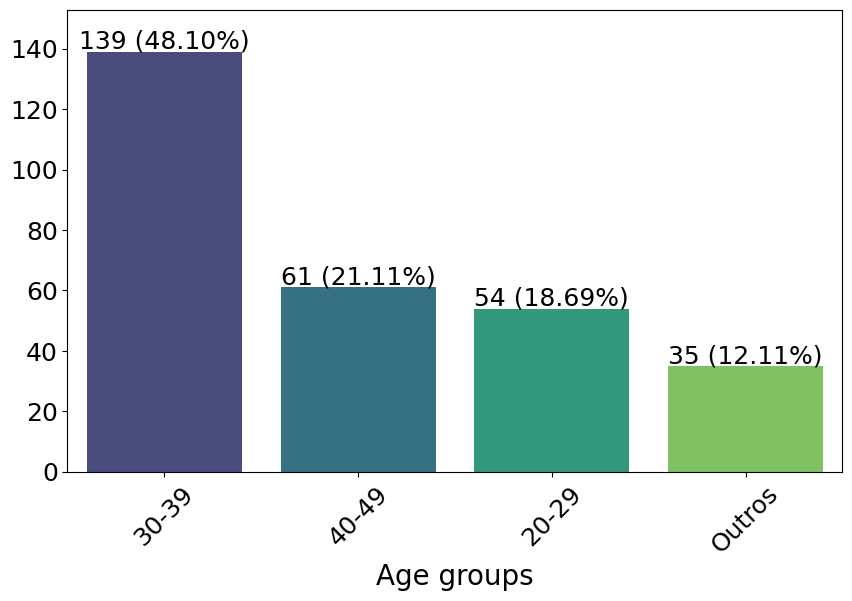

In [71]:
age_group0 = df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 0]['AGE_GROUP'].apply(
    lambda x: x if x in ['30-39', '40-49', '20-29'] else 'Outros'
)
age_group0_counts = age_group0.value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=age_group0_counts.index, y=age_group0_counts.values, palette="viridis")
plt.title('', fontsize=16)
plt.xlabel('Age groups', fontsize=20)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)

y_limit = age_group0_counts.max() * 1.1
ax.set_ylim(0, y_limit)

total = age_group0_counts.sum()  # Total de ocorrências
for i, count in enumerate(age_group0_counts):
    percentage = (count / total) * 100
    plt.text(i, count + 1, f'{count} ({percentage:.2f}%)', ha='center', fontsize=18)


plt.show()

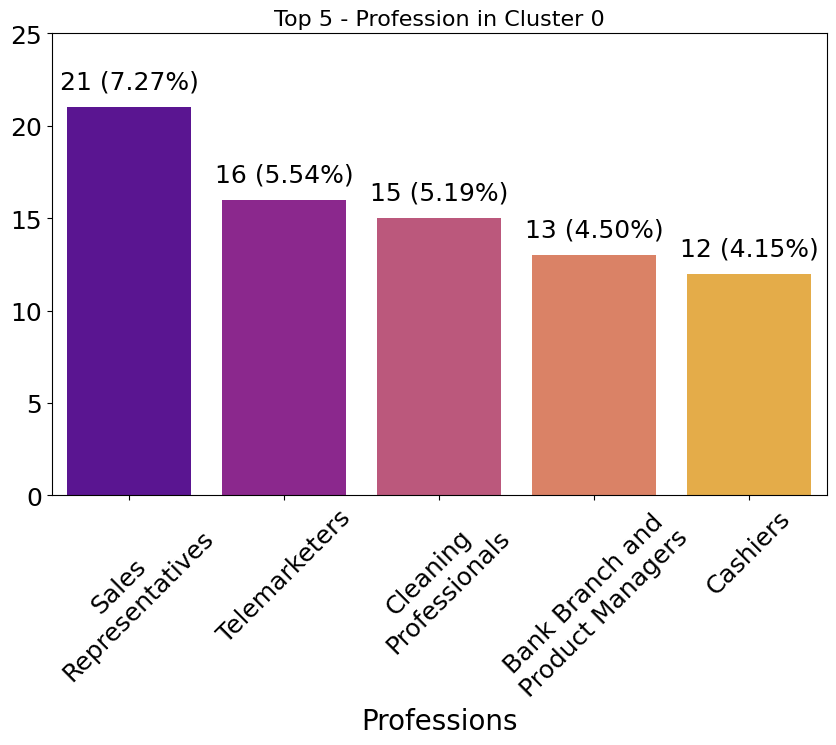

In [72]:
import textwrap

# Dicionário de tradução
translation_dict = {
    'Vendedores': 'Sales Representatives',
    'Operadores de telemarketing': 'Telemarketers',
    'Gerentes de agência e produtos bancários': 'Bank Branch and Product Managers',
    'Caixas': 'Cashiers',
    'Profissionais de limpeza': 'Cleaning Professionals'
}

# Filtrando e traduzindo as profissões para o Cluster 0
profissao0 = df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 0]['PROFISSAO'].apply(
    lambda x: translation_dict[x] if x in translation_dict else 'Others'  # Mantenha 'Others' como categoria
)

# Contando os valores e ordenando em ordem decrescente
profissao0_counts = profissao0.value_counts().sort_values(ascending=False)

# Mantendo apenas os 5 mais frequentes (excluindo 'Others' do gráfico)
top_profissoes = profissao0_counts[profissao0_counts.index != 'Others'].head(5)

# Criando o histograma
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_profissoes.index, y=top_profissoes.values, palette="plasma")

# Configuração dos rótulos e título
plt.title('Top 5 - Profession in Cluster 0', fontsize=16)
plt.xlabel('Professions', fontsize=20)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)

# Ajustando o limite do eixo Y
y_limit = 25  # Use o máximo de todas as contagens
ax.set_ylim(0, y_limit)

# Adicionando a contagem e porcentagem sobre as barras
total = profissao0_counts.sum()  # Total de ocorrências, incluindo 'Others'
for i, count in enumerate(top_profissoes):
    percentage = (count / total) * 100
    plt.text(i, count + 1, f'{count} ({percentage:.2f}%)', ha='center', fontsize=18)

# Adicionando o wrapping nos rótulos das profissões
wrapped_labels = [textwrap.fill(label, width=20) for label in top_profissoes.index]
ax.set_xticklabels(wrapped_labels, fontsize=18)

# Exibindo o gráfico
plt.show()


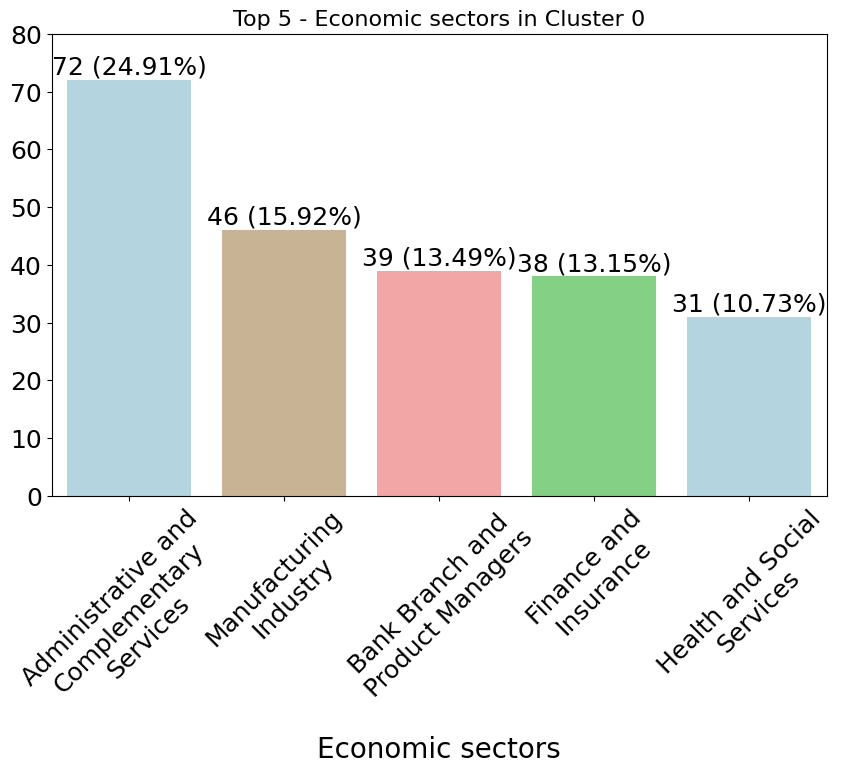

In [73]:
import textwrap


colors = {
    'Finance and Insurance': '#FF9999',  # Light pastel red
    'Administrative and Complementary Services': '#ADD8E6',  # Light blue
    'Manufacturing Industry': '#D2B48C',  # Light brown
    'Health and Social Services': '#77DD77',  # Darker green
    'Commerce': '#FFB3E6',  # Light purple
    'Professional, Scientific, and Technical Activities': '#A9A9A9',  # Gray
    'Not Informed': '#333333',  # Black
    'Education': '#FFA500',  # Orange
    'Transportation, Storage, and Post': '#DDA0DD',  # Purple
    'Accommodation and Food': '#FFD700',  # Yellow
}

# Dicionário de tradução
translation_dict = {
    'Administrativo e Serviços complementares': 'Administrative and Complementary Services',
    'Indústria de Transformação': 'Manufacturing Industry',
    'Comércio': 'Bank Branch and Product Managers',
    'Financeiro e Seguros': 'Finance and Insurance',
    'Saúde e Serviços Sociais': 'Health and Social Services'
}

# Filtrando e traduzindo as profissões para o Cluster 0
area0 = df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 0]['AREA'].apply(
    lambda x: translation_dict[x] if x in translation_dict else 'Others'  # Mantenha 'Others' como categoria
)

# Contando os valores e ordenando em ordem decrescente
area0_counts = area0.value_counts().sort_values(ascending=False)

# Mantendo apenas os 5 mais frequentes (excluindo 'Others' do gráfico)
top_area = area0_counts[area0_counts.index != 'Others'].head(5)

# Criando o histograma
plt.figure(figsize=(10, 6))

color_list = [colors[area] for area in top_area.index if area in colors]


ax = sns.barplot(x=top_area.index, y=top_area.values, palette=color_list)

# Configuração dos rótulos e título
plt.title('Top 5 - Economic sectors in Cluster 0', fontsize=16)
plt.xlabel('Economic sectors', fontsize=20)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)

# Ajustando o limite do eixo Y
y_limit = 80  # Use o máximo de todas as contagens
ax.set_ylim(0, y_limit)

# Adicionando a contagem e porcentagem sobre as barras
total = area0_counts.sum()  # Total de ocorrências, incluindo 'Others'
for i, count in enumerate(top_area):
    percentage = (count / total) * 100
    plt.text(i, count + 1, f'{count} ({percentage:.2f}%)', ha='center', fontsize=18)

# Adicionando o wrapping nos rótulos das profissões
wrapped_labels = [textwrap.fill(label, width=20) for label in top_area.index]
ax.set_xticklabels(wrapped_labels, fontsize=18)

# Exibindo o gráfico
plt.show()


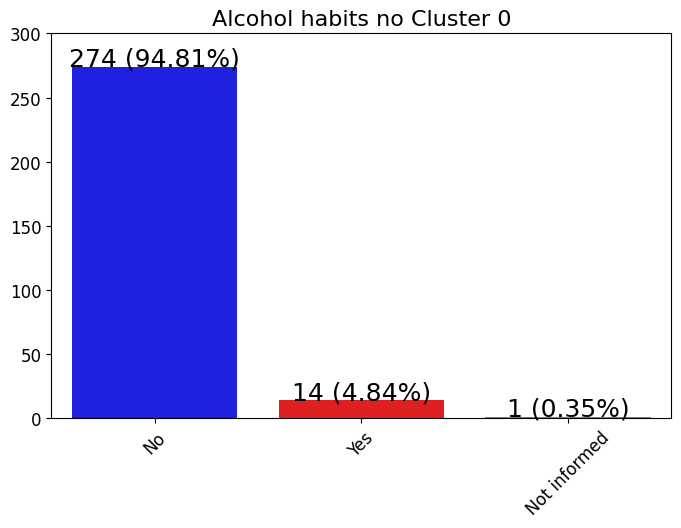

In [74]:
alcool_counts = df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 0]['ALCOOL'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=alcool_counts.index, y=alcool_counts.values, palette=['blue','red','gray'])

# Configurando o título e os rótulos
plt.title('Alcohol habits no Cluster 0', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando a contagem e porcentagem sobre as barras
total = alcool_counts.sum()  # Total de ocorrências
for i, count in enumerate(alcool_counts):
    percentage = (count / total) * 100
    plt.text(i, count + 1, f'{count} ({percentage:.2f}%)', ha='center', fontsize=18)

y_limit = 300  # Use o máximo de todas as contagens
ax.set_ylim(0, y_limit)


# Exibindo o gráfico
plt.show()

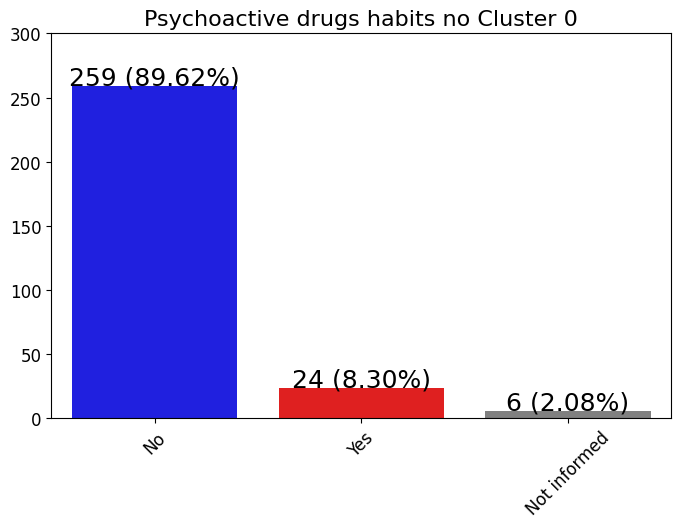

In [75]:
drogas_count = df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 0]['DROGAS'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=drogas_count.index, y=drogas_count.values, palette=['blue','red','gray'])

# Configurando o título e os rótulos
plt.title('Psychoactive drugs habits no Cluster 0', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando a contagem e porcentagem sobre as barras
total = drogas_count.sum()  # Total de ocorrências
for i, count in enumerate(drogas_count):
    percentage = (count / total) * 100
    plt.text(i, count + 1, f'{count} ({percentage:.2f}%)', ha='center', fontsize=18)

y_limit = 300  # Use o máximo de todas as contagens
ax.set_ylim(0, y_limit)


# Exibindo o gráfico
plt.show()

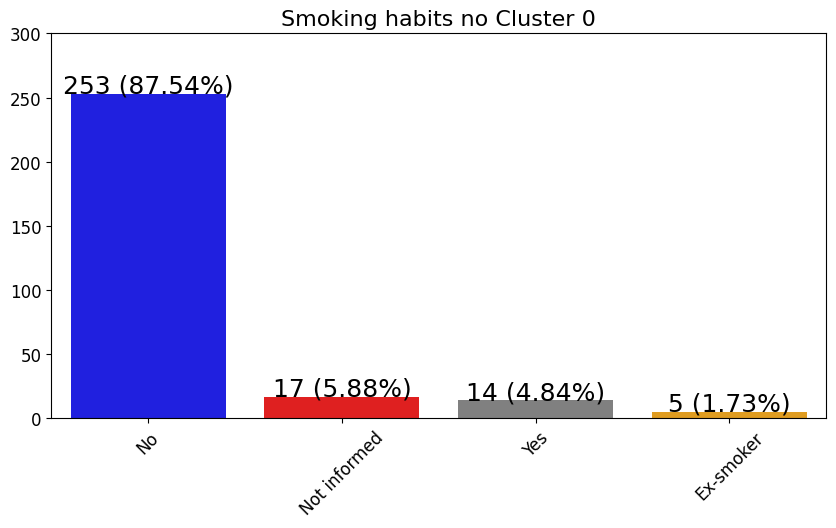

In [76]:
smoking_count = df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 0]['FUMA'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=smoking_count.index, y=smoking_count.values, palette=['blue','red','gray','orange'])

# Configurando o título e os rótulos
plt.title('Smoking habits no Cluster 0', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando a contagem e porcentagem sobre as barras
total = smoking_count.sum()  # Total de ocorrências
for i, count in enumerate(smoking_count):
    percentage = (count / total) * 100
    plt.text(i, count + 1, f'{count} ({percentage:.2f}%)', ha='center', fontsize=18)

y_limit = 300  # Use o máximo de todas as contagens
ax.set_ylim(0, y_limit)


# Exibindo o gráfico
plt.show()

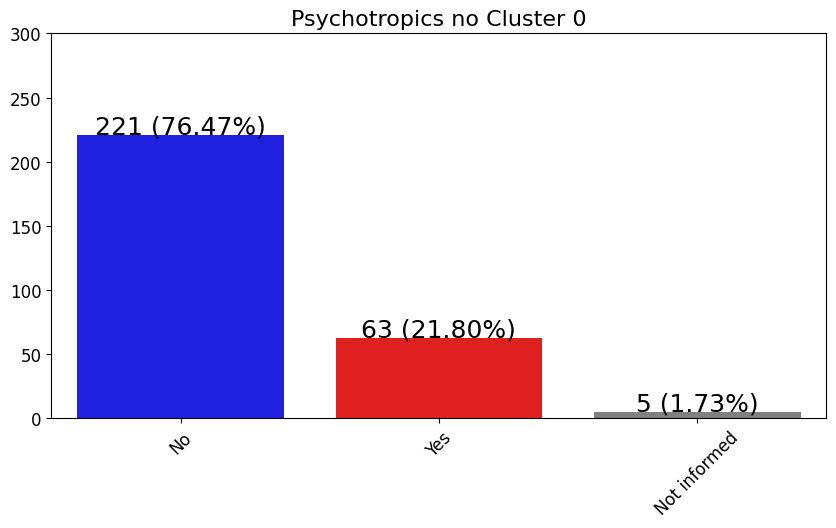

In [77]:
farm_count = df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 0]['PSICO_FARM'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=farm_count.index, y=farm_count.values, palette=['blue','red','gray','orange'])

# Configurando o título e os rótulos
plt.title('Psychotropics no Cluster 0', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando a contagem e porcentagem sobre as barras
total = farm_count.sum()  # Total de ocorrências
for i, count in enumerate(farm_count):
    percentage = (count / total) * 100
    plt.text(i, count + 1, f'{count} ({percentage:.2f}%)', ha='center', fontsize=18)

y_limit = 300  # Use o máximo de todas as contagens
ax.set_ylim(0, y_limit)


# Exibindo o gráfico
plt.show()

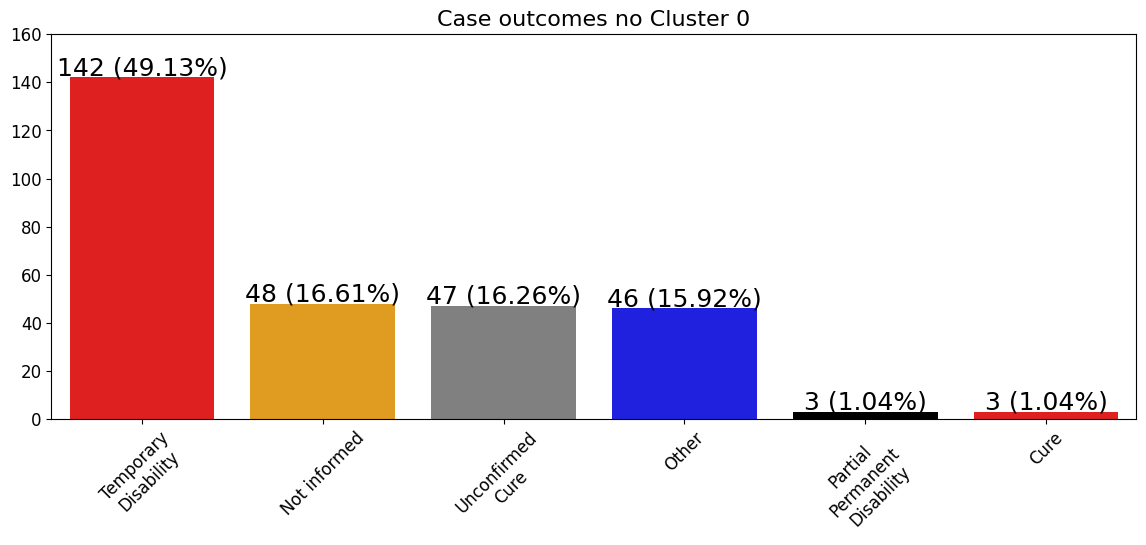

In [78]:
outcome_counts = df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 0]['EVOLUCAO'].value_counts()

# Criando o gráfico de barras
plt.figure(figsize=(14, 5))
ax = sns.barplot(x=outcome_counts.index, y=outcome_counts.values, palette=['red','orange','gray','blue', 'black'])

# Configurando o título e os rótulos
plt.title('Case outcomes no Cluster 0', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adicionando a contagem e porcentagem sobre as barras
total = outcome_counts.sum()  # Total de ocorrências
for i, count in enumerate(outcome_counts):
    percentage = (count / total) * 100
    plt.text(i, count + 1, f'{count} ({percentage:.2f}%)', ha='center', fontsize=18)

y_limit = 160  # Use o máximo de todas as contagens
ax.set_ylim(0, y_limit)

wrapped_labels = [textwrap.fill(label, width=15) for label in outcome_counts.index]
ax.set_xticklabels(wrapped_labels, fontsize=12)

# Exibindo o gráfico
plt.show()

In [79]:
from sklearn.preprocessing import OneHotEncoder
df_sp_a2_cluster['Cluster'] = clusters2

features = df_sp_a2_cluster.drop(columns=['Cluster'])  # Dados para codificar
clusters = df_sp_a2_cluster['Cluster']  # Clusters para identificar grupos
encoder = OneHotEncoder()
features_encoded = encoder.fit_transform(features).toarray()

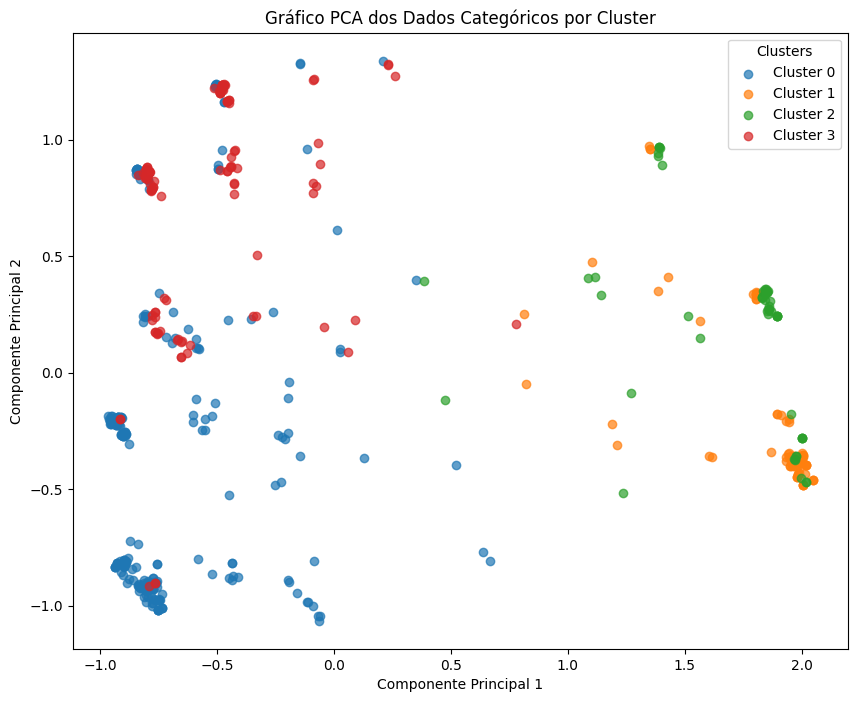

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_encoded)
plt.figure(figsize=(10, 8))
unique_clusters = np.unique(clusters)

# Plotar cada cluster com uma cor diferente
for cluster in unique_clusters:
    cluster_data = principal_components[clusters == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', alpha=0.7)

# Personalizar o gráfico
plt.title("Gráfico PCA dos Dados Categóricos por Cluster")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clusters")
plt.show()

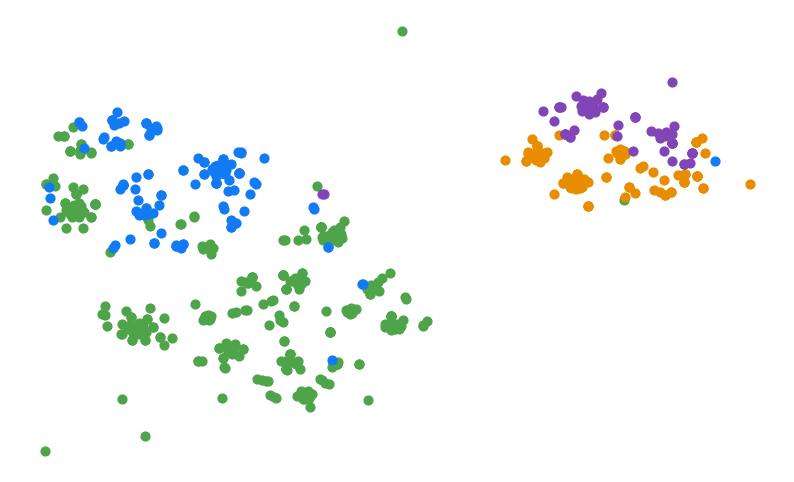

In [81]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=10)
tsne_components = tsne.fit_transform(features_encoded)

cluster_colors = ['#4EA449', '#E88C00', '#8245B8', '#117AF5']

# Plotar o gráfico t-SNE
plt.figure(figsize=(10, 6))
unique_clusters = np.unique(clusters)

# Plotar cada cluster com uma cor diferente
for i, cluster in enumerate(unique_clusters):
    cluster_data = tsne_components[clusters == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color=cluster_colors[i % len(cluster_colors)],
                label=f'Cluster {cluster}', alpha=1, s=40)

# Personalizar o gráfico
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])  # Remove os valores do eixo X
plt.yticks([])  # Remove os valores do eixo Y
plt.gca().spines['top'].set_visible(False)    # Remove a borda superior
plt.gca().spines['right'].set_visible(False)  # Remove a borda direita
plt.gca().spines['left'].set_visible(False)    # Remove a borda esquerda
plt.gca().spines['bottom'].set_visible(False)   # R
#plt.legend(title="", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(unique_clusters), fontsize=22)
plt.show()

In [82]:
df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 3]['PSICO_FARM'].value_counts()

,count
PSICO_FARM,
Yes,114
No,5
Not informed,2


In [83]:
df_sp_a2_cluster_final[df_sp_a2_cluster_final['Cluster'] == 3][['EVOLUCAO']].value_counts()

,count
EVOLUCAO,
Temporary Disability,92
Other,12
Not informed,7
Unconfirmed Cure,7
Partial Permanent Disability,2
Cure,1


## Regras de Associação - Apriori

In [84]:
!pip uninstall mlxtend --quiet
!pip install mlxtend==0.23.1 --quiet

Found existing installation: mlxtend 0.23.1
Uninstalling mlxtend-0.23.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/mlxtend-0.23.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/mlxtend/*
Proceed (Y/n)? Y
  Successfully uninstalled mlxtend-0.23.1




In [85]:
conditions1 = (
    (df_sp_a1_cluster['ALCOOL'] == 'Not informed') &
    (df_sp_a1_cluster['DROGAS'] == 'Not informed') &
    (df_sp_a1_cluster['PSICO_FARM'] == 'Not informed') &
    (df_sp_a1_cluster['FUMA'] == 'Not informed')
)

print(df_sp_a1_cluster.shape)
df_sp_a1_cluster_cleaned = df_sp_a1_cluster[~conditions1].copy()
print(df_sp_a1_cluster_cleaned.shape)
#df_sp_a1_cluster_cleaned = df_sp_a1_cluster.copy()
#print(df_sp_a1_cluster_cleaned.shape)

conditions2 = (
    (df_sp_a2_cluster['ALCOOL'] == 'Not informed') &
    (df_sp_a2_cluster['DROGAS'] == 'Not informed') &
    (df_sp_a2_cluster['PSICO_FARM'] == 'Not informed') &
    (df_sp_a2_cluster['FUMA'] == 'Not informed')
)

print(df_sp_a2_cluster.shape)
df_sp_a2_cluster_cleaned = df_sp_a2_cluster[~conditions2].copy()
print(df_sp_a2_cluster_cleaned.shape)
#df_sp_a2_cluster_cleaned = df_sp_a2_cluster.copy()
#print(df_sp_a2_cluster_cleaned.shape)

(520, 7)
(369, 7)
(563, 8)
(439, 8)


In [86]:
'''columns_to_encode = ['AGE_GROUP', 'PROFISSAO', 'AREA', 'ALCOOL',
                     'DROGAS', 'PSICO_FARM', 'FUMA',
                     'EVOLUCAO', 'CAPES', 'SITUACAO', 'PERIODO']
'''
columns_to_encode = ['AGE_GROUP', 'PROFISSAO','ALCOOL',
                     'DROGAS', 'PSICO_FARM', 'FUMA',
                     'EVOLUCAO']

# Usando pd.get_dummies para a codificação one-hot
df_encoded1 = pd.get_dummies(df_sp_a1_cluster_cleaned[columns_to_encode].reset_index(drop=True), drop_first=True)
df_encoded2 = pd.get_dummies(df_sp_a2_cluster_cleaned[columns_to_encode].reset_index(drop=True), drop_first=True)

In [87]:
from mlxtend.frequent_patterns import apriori, association_rules
# Gerando itemsets frequentes
frequent_itemsets1 = apriori(df_encoded1, min_support=0.10, use_colnames=True)
frequent_itemsets2 = apriori(df_encoded2, min_support=0.10, use_colnames=True)

# Gerando regras de associação
rules1 = association_rules(frequent_itemsets1, metric="lift", min_threshold=1)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

In [88]:
strong_rules1 = rules1[(rules1['lift'] > 1.2) & (rules1['confidence'] >= 0.70)]
strong_rules1_filtered = strong_rules1[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
strong_rules1_filtered['support_perc'] = (strong_rules1_filtered['support'] * 100).round(2)
strong_rules1_filtered['confidence_perc'] = (strong_rules1_filtered['confidence'] * 100).round(2)
strong_rules1_filtered['lift_2'] = (strong_rules1_filtered['lift']).round(2)
strong_rules1_filtered = strong_rules1_filtered[strong_rules1_filtered['consequents'].apply(lambda x: 'EVOLUCAO_Temporary Disability' in x)]
strong_rules1_sorted = strong_rules1_filtered.loc[strong_rules1_filtered.groupby('antecedents')['confidence'].idxmax()]
strong_rules1_sorted = strong_rules1_sorted.sort_values(by='confidence', ascending=False)
pd.DataFrame(strong_rules1_sorted)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,support,confidence,lift,support_perc,confidence_perc,lift_2
19,"(AGE_GROUP_30-39, PSICO_FARM_Yes)",(EVOLUCAO_Temporary Disability),0.102981,0.745098,1.205882,10.3,74.51,1.21
43,"(FUMA_No, PSICO_FARM_Yes)",(EVOLUCAO_Temporary Disability),0.205962,0.745098,1.205882,20.6,74.51,1.21


In [89]:
strong_rules2 = rules2[(rules2['lift'] >= 1.2) & (rules2['confidence'] >= 0.70)]
strong_rules2_filtered = strong_rules2[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
strong_rules2_filtered['support_perc'] = (strong_rules2_filtered['support'] * 100).round(2)
strong_rules2_filtered['confidence_perc'] = (strong_rules2_filtered['confidence'] * 100).round(2)
strong_rules2_filtered['lift_2'] = (strong_rules2_filtered['lift']).round(2)
#strong_rules2_filtered = strong_rules2_filtered[strong_rules2_filtered['consequents'] != frozenset({'PSICO_FARM_Yes'})]
strong_rules2_filtered = strong_rules2_filtered[strong_rules2_filtered['consequents'].apply(lambda x: 'EVOLUCAO_Temporary Disability' in x)]
# Agrupar por antecedents e pegar a linha com maior confidence para cada grupo
strong_rules2_sorted = strong_rules2_filtered.loc[strong_rules2_filtered.groupby('antecedents')['confidence'].idxmax()]
strong_rules2_sorted = strong_rules2_sorted.sort_values(by='confidence', ascending=False)
pd.DataFrame(strong_rules2_sorted)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,support,confidence,lift,support_perc,confidence_perc,lift_2
52,"(FUMA_No, DROGAS_Yes)",(EVOLUCAO_Temporary Disability),0.102506,0.937500,1.652861,10.25,93.75,1.65
14,(DROGAS_Yes),(EVOLUCAO_Temporary Disability),0.111617,0.890909,1.570719,11.16,89.09,1.57
59,"(FUMA_No, PSICO_FARM_Yes)",(EVOLUCAO_Temporary Disability),0.264237,0.773333,1.363427,26.42,77.33,1.36
27,"(AGE_GROUP_30-39, PSICO_FARM_Yes)",(EVOLUCAO_Temporary Disability),0.118451,0.764706,1.348216,11.85,76.47,1.35
41,"(AGE_GROUP_40-49, PSICO_FARM_Yes)",(EVOLUCAO_Temporary Disability),0.111617,0.753846,1.329070,11.16,75.38,1.33
17,(PSICO_FARM_Yes),(EVOLUCAO_Temporary Disability),0.332574,0.752577,1.326833,33.26,75.26,1.33


In [91]:
import plotly.graph_objects as go

# Converter as colunas 'support' e 'confidence' para float
strong_rules2_sorted['support'] = strong_rules2_sorted['support'].astype(float)
strong_rules2_sorted['confidence'] = strong_rules2_sorted['confidence'].astype(float)

# Converter 'antecedents' e 'consequents' de sets para strings (se necessário)
strong_rules2_sorted['antecedents'] = strong_rules2_sorted['antecedents'].apply(lambda x: ', '.join(list(x)))
strong_rules2_sorted['consequents'] = strong_rules2_sorted['consequents'].apply(lambda x: ', '.join(list(x)))

# Criar o gráfico de dispersão
fig = go.Figure(data=go.Scatter(
    x=strong_rules2_sorted['support'] * 100,  # Suporte em porcentagem
    y=strong_rules2_sorted['confidence'] * 100,  # Confiança em porcentagem
    mode='markers',
    text=strong_rules2_sorted['antecedents'] + ' -> ' + strong_rules2_sorted['consequents'],  # Texto do hover
    hoverinfo='text',
    marker=dict(
        size=strong_rules2_sorted['lift'] * 30,  # Tamanho da bolha com base no lift
        color=strong_rules2_sorted['lift'],  # Cor com base no lift
        colorscale='Portland',  # Paleta de cores do Plotly
        showscale=True,
        colorbar=dict(
            title="Lift"  # Barra de cores indicando o lift
        )
    )
))

# Customizar o layout
fig.update_traces(textposition='middle right', textfont=dict(size=20))
fig.update_layout(
    width=800, height=800,
    xaxis_title='Support (%)',
    yaxis_title='Confidence (%)',
    font=dict(size=18, color="black"),
    xaxis=dict(tickfont=dict(size=20, color="black")),
    yaxis=dict(tickfont=dict(size=20, color="black"))
)

# Personalizar as bolhas e os eixos
fig.update_traces(marker=dict(line=dict(width=2, color="black")))
fig.update_xaxes(linewidth=2, linecolor='black')
fig.update_yaxes(linewidth=2, linecolor='black')

# Definir a cor de fundo do gráfico
fig.update_layout(plot_bgcolor="#FFFFFF")

# Remover a legenda
fig.update_layout(showlegend=False)

# Exibir o gráfico
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

